In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pylab as plt
from matplotlib import colors, cm
from astropy.io import fits, ascii
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.cosmology import default_cosmology
import glob
import matplotlib as mpl
import pandas as pd
from astropy.coordinates import SkyCoord

In [2]:
lcdm = default_cosmology.get()

In [3]:
grpcat = fits.open('../eFEDS_clusters_V3.2.fits')[1].data
grpcat.dtype

dtype((numpy.record, [('ID', 'S22'), ('ID_SRC', '>i4'), ('RA', '>f8'), ('DEC', '>f8'), ('EXT_LIKE', '>f4'), ('DET_LIKE', '>f4'), ('z', '>f8'), ('z_type', '>i4'), ('T_300kpc', '>f8'), ('T_300kpc_L', '>f8'), ('T_300kpc_U', '>f8'), ('L_300kpc', '>f8'), ('L_300kpc_L', '>f8'), ('L_300kpc_U', '>f8'), ('Lbol_300kpc', '>f8'), ('Lbol_300kpc_L', '>f8'), ('Lbol_300kpc_U', '>f8'), ('F_300kpc', '>f8'), ('F_300kpc_L', '>f8'), ('F_300kpc_U', '>f8'), ('T_500kpc', '>f8'), ('T_500kpc_L', '>f8'), ('T_500kpc_U', '>f8'), ('L_500kpc', '>f8'), ('L_500kpc_L', '>f8'), ('L_500kpc_U', '>f8'), ('Lbol_500kpc', '>f8'), ('Lbol_500kpc_L', '>f8'), ('Lbol_500kpc_U', '>f8'), ('F_500kpc', '>f8'), ('F_500kpc_L', '>f8'), ('F_500kpc_U', '>f8'), ('SNR_MAX', '>f4'), ('R_SNR_MAX', '>f4')]))

In [4]:
ptsrc = fits.open('../ptsrc_cat.fits')[1].data
# ptsrc_lowsig = fits.open('ptsrc_lowsig.fits')[1].data

In [5]:
ptsrc.dtype

dtype((numpy.record, [('ID_SRC', '>i4'), ('RA', '>f8'), ('DEC', '>f8'), ('RADEC_ERR', '>f4'), ('EXT', '>f4'), ('EXT_ERR', '>f4'), ('EXT_LIKE', '>f4'), ('ML_CTS', '>f4'), ('ML_CTS_ERR', '>f4'), ('ML_RATE', '>f4'), ('ML_RATE_ERR', '>f4'), ('ML_FLUX', '>f4'), ('ML_FLUX_ERR', '>f4'), ('DET_LIKE', '>f4'), ('ML_BKG', '>f4'), ('ML_EXP', '>f4'), ('RA_CORR', '>f8'), ('DEC_CORR', '>f8'), ('RADEC_ERR_CORR', '>f8'), ('ML_CTS_s', '>f8'), ('ML_CTS_ERR_s', '>f8'), ('DET_LIKE_s', '>f8'), ('ML_BKG_s', '>f8'), ('ML_EXP_s', '>f8'), ('ML_FLUX_s', '>f8'), ('ML_FLUX_ERR_s', '>f8'), ('ML_RATE_s', '>f8'), ('ML_RATE_ERR_s', '>f8'), ('APE_CTS_s', '>i4'), ('APE_BKG_s', '>f8'), ('APE_EXP_s', '>f8'), ('APE_RADIUS_s', '>f8'), ('APE_POIS_s', '>f8'), ('ML_CTS_u', '>f8'), ('ML_CTS_ERR_u', '>f8'), ('DET_LIKE_u', '>f8'), ('ML_BKG_u', '>f8'), ('ML_EXP_u', '>f8'), ('ML_FLUX_u', '>f8'), ('ML_FLUX_ERR_u', '>f8'), ('ML_RATE_u', '>f8'), ('ML_RATE_ERR_u', '>f8'), ('APE_CTS_u', '>i4'), ('APE_BKG_u', '>f8'), ('APE_EXP_u', '>f8')

(0.0, 6000.0)

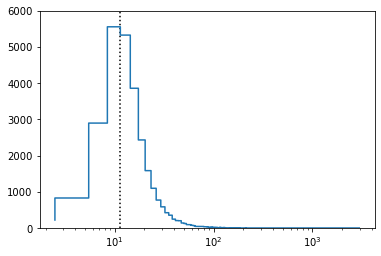

In [6]:
cts = ptsrc['APE_CTS_s'] + ptsrc['APE_CTS_t'] + ptsrc['APE_CTS_u']
hist, bins = np.histogram(cts, bins=1000, range=(1, cts.max()))
x = (bins[:-1]+bins[1:])/2.
plt.step(x, hist)
plt.xscale('log')
plt.vlines(x[np.argmax(hist)], 0, 6000, color='k', linestyle='dotted')
plt.ylim(0,6000)

(0.0, 140.0)

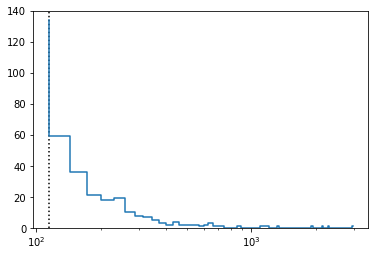

In [653]:
hist, bins = np.histogram(cts, bins=100, range=(100, cts.max()))
x = (bins[:-1]+bins[1:])/2.
plt.step(x, hist)
plt.xscale('log')
plt.vlines(x[np.argmax(hist)], 0, 140, color='k', linestyle='dotted')
plt.ylim(0,140)

In [475]:
def make_regions(catalog, type='grp', nrad=1,maskrad_kpc=None, shape='circle', nannuli=10, maxrad=100, minrad=0, log=False, x=None):
    output = []
    if type == 'gal':
        ra = catalog['ra']*u.degree
        dec = catalog['dec']*u.degree
    elif type in ['grp', 'pts']:
        ra = catalog['RA']*u.degree
        dec = catalog['DEC']*u.degree
    else:
        print('Invalid type')
    if type == 'pts':
        rad = catalog['APE_RADIUS_s']*4*u.arcsec.to('arcmin')*nrad
    elif type == 'grp':
        rad = catalog['R_SNR_MAX_ARCMIN']*nrad
    else: 
        try:
            dA = lcdm.angular_diameter_distance(catalog['redshift']).to('kpc').value #kpc per radian
        except KeyError:
            try: 
                dA = lcdm.angular_diameter_distance(catalog['z'].value).to('kpc').value
            except AttributeError:
                dA = lcdm.angular_diameter_distance(catalog['z'].values).to('kpc').value
        dA *= u.arcmin.to('radian') #kpc per arcmin
    for i in range(len(catalog)): 
        c = SkyCoord(ra[i], dec[i])
        r, d = c.to_string('hmsdms').split(' ')
        r = r.replace('h',':').replace('m',':').replace('s','')
        d = d.replace('d',':').replace('m',':').replace('s','')
        if shape == 'circle':
            if type =='gal':
                rad = maskrad_kpc/dA[i]
            output.append(shape+"(%s,%s,%0.5f')" % (r,d,rad[i]))
        elif shape == 'annulus':
            if x:
                bins = x/dA[i]
            else:
                if log:
                    if not minrad:
                        minrad = 1
                    bins = (10**np.linspace(np.log10(minrad), np.log10(maxrad), nannuli+1))/dA[i]
                else:
                    bins = np.linspace(minrad, maxrad, nannuli+1)/dA[i]
            for i in range(len(bins)-1):
                output.append(shape+"(%s,%s,%0.5f',%0.5f')" % (r,d,bins[i],bins[1+i]))
        else:
            print('Invalid shape')
    return output

In [8]:
grpmask = make_regions(grpcat, type='grp', shape='circle')

In [9]:
ptsmask = make_regions(ptsrc, type='pts', shape='circle')

In [11]:
with open('ptsrc.reg','w') as f:
    f.writelines(ptsmask)

In [40]:
# ptsmask_lowsig = make_regions(ptsrc_lowsig, type='pts')

In [7]:
sdss = ascii.read('../SDSS/sdss_output.csv', delimiter=',')
sdss = sdss[(sdss['logMass'] > 10.2)*(sdss['logMass'] < 11.2)]
# sdss = ascii.read('../Skyserver_SQL2_3_2022 5_42_08 PM.csv', delimiter=',')
sdss.keys()

['ra', 'dec', 'z', 'logMass', 'ssfr']

In [8]:
mass1 = (sdss['logMass'] > 10.2)*(sdss['logMass'] < 10.7)
mass2 = (sdss['logMass'] > 10.7)*(sdss['logMass'] < 11.2)
len(sdss[mass1]), len(sdss[mass2]), len(sdss)

(1482, 1161, 2643)

In [480]:
x = [0,5.5,10,20,40, 60, 100,150, 200, 250, 300]
annuli = make_regions(sdss_gama, type='gal', maskrad_kpc=None, shape='annulus', x=x)

In [481]:
with open('../sdss_gama.reg','w') as f:
    f.writelines(annuli)

# Galaxy Properties

In [5]:
sdss['ssfr'].min(), sdss['ssfr'].max()

(-33.0, -0.282896220684052)

[0.005 0.01  0.015 0.02  0.025 0.03  0.035 0.04  0.045 0.05  0.055 0.06
 0.065 0.07  0.075 0.08  0.085 0.09  0.095 0.1  ]
0.07514828825576995


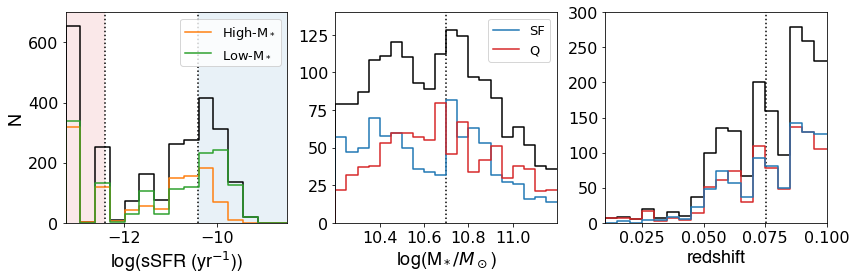

In [503]:
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
font = mpl.font_manager.FontProperties(family='helvetica', size=18)
(sdss['ssfr'][sdss['ssfr'] < -4]) = -4

low = sdss[(sdss['logMass'] < 10.7)*(sdss['logMass'] > 10.2)]
high = sdss[(sdss['logMass'] > 10.7)*(sdss['logMass'] < 11.2)]

fig, ax = plt.subplots(ncols = 3, figsize=(12,4))
ax1, ax2, ax3 = ax.flatten()
for a in (ax1, ax3): a.set_ylabel('N', fontsize=20, font=font)
    

hist, bins = np.histogram(sdss['ssfr']-9, bins=30, range=(-18,-8.5))
ax1.step(bins[1:], hist, color='k')

hist, bins = np.histogram(high['ssfr']-9, bins=30, range=(-18,-8.5))
ax1.step(bins[1:], hist, color='tab:orange', label=r'High-M$_*$')
hist, bins = np.histogram(low['ssfr']-9, bins=30, range=(-18,-8.5))
ax1.step(bins[1:], hist, color='tab:green', label=r'Low-M$_*$')
ax1.legend(loc='best',fontsize=13)

ax1.set_xlabel(r'log(sSFR (yr$^{-1}$))', fontsize=16, font=font)

q = np.argsort(sdss['ssfr'])[int(len(sdss)/3.)]
sf = np.argsort(sdss['ssfr'])[int(2*len(sdss)/3.)]
sfr1 = sdss['ssfr'][q] -9
sfr2 = sdss['ssfr'][sf] -9
ax1.vlines(sfr2, 0, 900, color='k', linestyle='dotted')
ax1.vlines(sfr1, 0, 900, color='k', linestyle='dotted')
ax1.bar(sfr2, 900, width=(1-sfr2), align='edge', alpha=0.1, color='tab:blue')
ax1.bar(sfr1, 900, width=(sfr1-10), align='edge', alpha=0.1, color='tab:red')
ax1.set_xlim(-13.25,-8.5)
ax1.set_ylim(0,700)

q1 = np.argsort(low['ssfr'])[:int(len(low)/3.)]
sf1 = np.argsort(low['ssfr'])[int(2*len(low)/3.):]
q2 = np.argsort(high['ssfr'])[:int(len(high)/3.)]
sf2 = np.argsort(high['ssfr'])[int(2*len(high)/3.):]

sf = np.concatenate((low['logMass'][sf1], high['logMass'][sf2]))
q = np.concatenate((low['logMass'][q1], high['logMass'][q2]))

hist, bins = np.histogram(np.concatenate((sf,q)), bins=21, range=(10.15,11.2))
ax2.step(bins[1:], hist, color='k')
hist, bins = np.histogram(sf, bins=21, range=(10.15,11.2))
ax2.step(bins[1:], hist, color='tab:blue', label='SF')
hist, bins = np.histogram(q, bins=21, range=(10.15,11.2))
ax2.step(bins[1:], hist, color='tab:red', label='Q')
ax2.vlines(x=10.7,ymin=0,ymax=485,color='k',linestyles='dotted')
ax2.set_ylim(0,140)
ax2.set_xlabel(r'log(M$_*/M_\odot$)', fontsize=16,font=font)
ax2.set_xlim(10.2,11.2)
ax2.legend(loc='best',fontsize=13)
ax2.set_xticks([10.4, 10.6, 10.8, 11.0])

sf = np.concatenate((low['z'][q1], high['z'][q2]))
q = np.concatenate((low['z'][sf1], high['z'][sf2]))
zmean = np.mean(sdss['z'][(sdss['z'] > 0.01)*(sdss['z'] < 0.1)])
ax3.vlines(x=zmean,ymin=0,ymax=550,color='k',linestyles='dotted')
hist, bins = np.histogram(np.concatenate((sf,q)), bins=19, range=(0.005,0.1))
ax3.step(bins[1:], hist, color='k')
hist, bins = np.histogram(sf, bins=19, range=(0.005,0.1))
ax3.step(bins[1:], hist, color='tab:red')
hist, bins = np.histogram(q, bins=19, range=(0.005,0.1))
print(bins)
ax3.step(bins[1:], hist, color='tab:blue')
ax3.set_xticks([0.025, 0.05, 0.075, 0.1])
ax3.set_xlim(0.01,0.1)

bins[np.argmax(hist)]
ax3.set_xlabel(r'redshift', fontsize=16, font=font)
ax3.set_ylim(0,300)

for a in ax.flatten(): ama = a.get_ylim()[1]; a.set_ylim(0,ama)
for a in [ax2,ax3]: a.set_ylabel('')


fig.tight_layout()
print(zmean)
plt.savefig('../galaxy-props.png', dpi=156)

In [101]:
grpoutput = []
for line in grpmask:
    grpoutput.append (line.replace('h',':').replace('m',':').replace('s ',',').replace('s,',',').replace('"','').replace('d',':'))

ptoutput = []
for line in ptsmask:
    ptoutput.append(line.replace('h',':').replace('m',':').replace('s ',',').replace('s,',',').replace('"','').replace('d',':'))
    
ptoutput_lowsig = []
for line in ptsmask_lowsig:
    ptoutput_lowsig.append(line.replace('h',':').replace('m',':').replace('s ',',').replace('s,',',').replace('"','').replace('d',':'))

In [106]:
with open('grp_cat.reg','w') as f:
    f.writelines(grpoutput)
    
with open('ptsrc_cat.reg','w') as f:
    f.writelines(ptoutput)
    
with open('ptsrc_cat_lowsig.reg','w') as f:
    f.writelines(ptoutput_lowsig)

In [8]:
def radec_to_pix(ra, dec, head):
    
    ra0 = head['CRVAL1']  #  =  1.3386000000000E+02                                                  
    rap0 = head['CRPIX1'] #  =  1.1249500000000E+04                                                  
    dra = head['CDELT1']  #  = -1.1111111276679E-03                                                  
    dec0 = head['CRVAL2'] #  =  1.5000000000000E+00                                                  
    decp0 = head['CRPIX2']#  =  7.4995000000000E+03                                                  
    ddec = head['CDELT2'] #  =  1.1111111276679E-03  
    
    rapix = (ra - ra0)/dra + rap0
    decpix = (dec - dec0)/ddec + decp0
    
    return rapix, decpix

In [11]:
img = fits.getdata('../img_0520_12346_excl_grp_pts.fits')
head = fits.getheader('../img_0520_12346_excl_grp_pts.fits')
rapix, decpix = radec_to_pix(sdss['ra'], sdss['dec'], head)

In [12]:
rapix.min(), rapix.max(), decpix.min(), decpix.max(), img.shape

(-1825.7662317734885,
 16110.9312767981,
 7521.038783732083,
 14047.617266132376,
 (19999, 19999))

In [17]:
ratix = np.array([125,130,135,140,145])
dectix = np.array([-2,0,2,4,6])
xtix, ytix = radec_to_pix(ratix, dectix, head)

c = SkyCoord(ra=ratix*u.deg, dec=dectix*u.deg)

(3000.0, 12000.0)

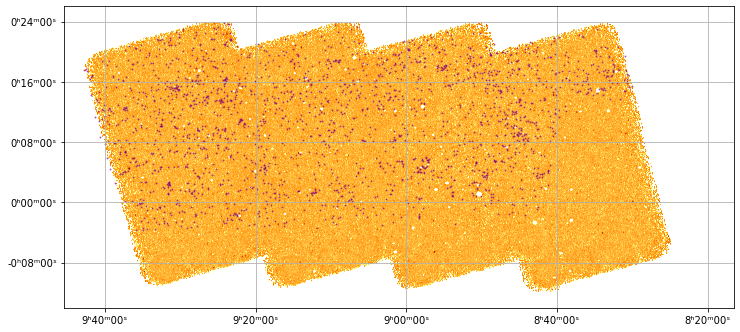

In [22]:
fig, ax = plt.subplots(figsize=(12,36))
plt.imshow(img,origin='lower',cmap=cm.afmhot_r, norm=colors.LogNorm(img.max()/1e6,img.max()))
plt.scatter(rapix, decpix, color='purple', alpha=0.5, s=1)
plt.xticks(xtix, c.ra.to_string(unit=u.hourangle, fields=3, format='unicode'))
plt.yticks(ytix, c.dec.to_string(unit=u.hourangle, fields=3, format='unicode'))
plt.grid(True)
plt.ylim(3000,12000)

In [10]:
def crossmatch(gal_region_file, sdss, tab=False, arr=False):
	#gal_region_file contains the dmcopy or dmextract regions
	#sdss is a table
	inds = []
	if tab:
		for i in range(len(gal_region_file)):
			inds.append(np.argmin(abs(sdss['ra'] - gal_region_file['ra'].iloc[i]) + abs(sdss['dec'] - gal_region_file['dec'].iloc[i])))
	elif arr:
		for i in range(len(gal_region_file)):
			inds.append(np.argmin(abs(sdss['ra'] - gal_region_file[i,0]) + abs(sdss['dec'] - gal_region_file[i,1])))
	else:
		with open(gal_region_file) as f:
			a = f.readlines()
		c = a[::15]
		print(len(a), len(b), len(c))
		tra = [l.split('(')[1].split(',')[0] for l in c]
		tdec = [l.split(',')[1] for l in c]
		for i in range(len(tra)):
			radec = SkyCoord(tra[i]+' '+tdec[i], unit=(u.hourangle, u.deg))
			inds.append(np.argmin(abs(sdss['ra'] - radec.ra.to('deg').value) + abs(sdss['dec'] - radec.dec.to('deg').value)))
	return inds


# Stacked images

In [11]:
def stacked_image(files, lenx, leny, inputtype='file'):
	img = np.zeros((lenx, leny))
	i = 0
	for file in files:
		if inputtype == 'file':
			f = fits.getdata(file)
		else:
			f = file
		x, y = f.shape
		# print(x,y)
		if y:
			starty = int((leny - y)/2)
			endy = starty+y
			startx = int((lenx - x)/2)
			endx = startx+x
			img[startx:endx,starty:endy] += f
	return ndimage.gaussian_filter(img, sigma=1, order=0)

In [12]:
lowstack = fits.getdata('../lowmass_stack.fits')
highstack = fits.getdata('../highmass_stack.fits')

In [13]:
def annulus(array, rmin, rmax):
    x = np.arange(array.shape[0])
    y = np.arange(array.shape[1])
    x = x - x.mean()
    y = y - y.mean()
    X, Y = np.meshgrid(x,y)
    r2 = X**2 + Y**2 
    return np.ma.masked_inside(r2, rmin**2, rmax**2).mask

In [14]:
bck_inds = annulus(lowstack, 25, 37.5)
low_bck = np.nanmedian(lowstack[bck_inds])
high_bck = np.nanmedian(highstack[bck_inds])
# print(np.nanmean(low_bck), np.nanmedian(low_bck), np.nanmean(lowstack), np.nanmedian(lowstack))

<ipython-input-376-7eab770acb7b>:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0,0,0.8,1])


Text(0.5, 91.25045454545455, 'X (")')

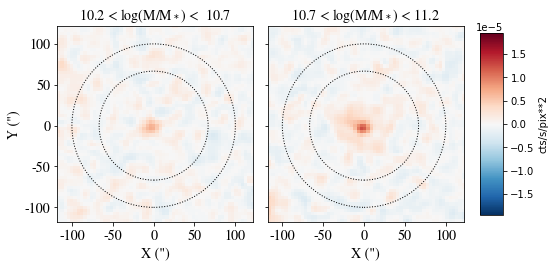

In [376]:
imlo = lowstack - low_bck
imhi = highstack - high_bck
zmin = min(imlo.min(), imhi.min())
zmax = max(imlo.max(), imhi.max())
fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(8,6))
ax1, ax2 = ax.flatten()
im = ax1.imshow(imlo, norm = colors.Normalize(-zmax, zmax), cmap=cm.RdBu_r)
ax2.imshow(imhi, norm = colors.Normalize(-zmax, zmax), cmap=cm.RdBu_r)
xtix = [-100,-50,0,50,100]
xpos = np.array(xtix)/4
xmean = np.mean(ax1.get_xlim())
xpos += xmean
ax1.set_yticks(xpos)
ax1.set_yticklabels(xtix,fontsize=14,fontfamily='STIXGeneral')
ax1.set_xticks(xpos)
ax1.set_xticklabels(xtix,fontsize=14,fontfamily='STIXGeneral')
ax2.set_xticks(xpos)
ax2.set_xticklabels(xtix,fontsize=14,fontfamily='STIXGeneral')
ax1.set_title(r'10.2 < log(M/M$_*$) <  10.7', fontfamily= 'STIXGeneral', fontsize=14)
ax2.set_title(r'10.7 < log(M/M$_*$) < 11.2', fontfamily= 'STIXGeneral', fontsize=14)
plt.xlim(45.5,105.5)
plt.ylim(45.5,105.5)
for a in [ax1, ax2]:
    src_circle = plt.Circle((xmean, xmean), 25, fill=False, color='k', linestyle='dotted')
    bck_circle = plt.Circle((xmean, xmean), 37.5, fill=False, color='k', linestyle='dotted')
    a.add_artist(src_circle)
    a.add_artist(bck_circle)
cb_ax = fig.add_axes([0.81,0.29,0.04,0.42])
cbar = fig.colorbar(im, cax=cb_ax)
cbar.set_label('cts/s/pix**2')
fig.tight_layout(rect=[0,0,0.8,1])
ax1.set_xlabel('X (")',fontsize=14,fontfamily= 'STIXGeneral')
ax1.set_ylabel('Y (")',fontsize=14,fontfamily= 'STIXGeneral')
ax2.set_xlabel('X (")',fontsize=14,fontfamily= 'STIXGeneral')

# Split above image by sSFR

In [15]:
src0520 = pd.read_csv('../src_bck_cts.csv')
src0510 = pd.read_csv('../src_bck_cts_0510.csv')

inds1 = crossmatch(src0520, sdss, tab=True, arr=True)
inds2 = crossmatch(src0510, sdss, tab=True, arr=True)

# Mass-Luminosity Relation

In [17]:
gals = ascii.read('../src_bck_cts.csv', delimiter=',', header_start=0)

In [10]:
fit[1]/1.45, fit[2]

(9.398277230033958, 1.5941697810277116)

In [54]:
eagle0510 = np.vstack((np.genfromtxt('../BenData/EAGLE_High-Mass.0.5_1.0keV.list.cat'), np.genfromtxt('../BenData/EAGLE_Low-Mass.0.5_1.0keV.list.cat')))
eagle1020 = np.vstack((np.genfromtxt('../BenData/EAGLE_High-Mass.1.0_2.0keV.list.cat'), np.genfromtxt('../BenData/EAGLE_Low-Mass.1.0_2.0keV.list.cat')))
tng0510 = np.vstack((np.genfromtxt('../BenData/TNG_High-Mass.0.5_1.0keV.list.cat'), np.genfromtxt('../BenData/TNG_Low-Mass.0.5_1.0keV.list.cat')))
tng1020 = np.vstack((np.genfromtxt('../BenData/TNG_High-Mass.1.0_2.0keV.list.cat'), np.genfromtxt('../BenData/TNG_Low-Mass.1.0_2.0keV.list.cat')))

Lx_tng = 10**tng0510[:,-3]   + 10**tng1020[:,-3]
Lx_eag = 10**eagle0510[:,-3] + 10**eagle1020[:,-3]
mtng = tng0510[:,3]
meag = eagle0510[:,3]

In [67]:
eag_low.shape

(4000, 8)

In [19]:
def sort(sdss):
    q = np.argsort(sdss['ssfr'])[:int(len(sdss)/3.)]
    sf = np.argsort(sdss['ssfr'])[int(2*len(sdss)/3.):]
    try: 
        return sf.values, q.values
    except AttributeError:
        return sf, q

In [24]:
#sSFRbin ID M200 MStar sSFR fCGM LX_all mean_keV_all nphot_all LX_soft mean_keV_soft nphot_soft LX_soft_ext mean_keV_soft_ext nphot_soft_ext
# tng_low = np.genfromtxt('../BenData/TNG_Low-Mass.0.5_1.0keV.list.cat')
# eag_low = np.genfromtxt('../BenData/EAGLE_Low-Mass.0.5_1.0keV.list.cat')
# tng_high = np.genfromtxt('../BenData/TNG_High-Mass.0.5_1.0keV.list.cat')
# eag_high = np.genfromtxt('../BenData/EAGLE_High-Mass.0.5_1.0keV.list.cat')

eag_low = np.vstack((np.genfromtxt('../All.EAGLE.Ms10.20_10.70.sSFR1of3.MStar_finebins.cat'),
                    np.genfromtxt('../All.EAGLE.Ms10.20_10.70.sSFR3of3.MStar_finebins.cat')))
tng_low = np.vstack((np.genfromtxt('../All.TNG.Ms10.20_10.70.sSFR1of3.MStar_finebins.cat'),
            np.genfromtxt('../All.TNG.Ms10.20_10.70.sSFR3of3.MStar_finebins.cat')))
# eag_low #GalID Mhalo MStar sSFR MBH gas Kappa sSFR_sample
eag_high = np.vstack((np.genfromtxt('../All.EAGLE.Ms10.70_11.20.sSFR1of3.MStar_finebins.cat'),
                    np.genfromtxt('../All.EAGLE.Ms10.70_11.20.sSFR3of3.MStar_finebins.cat')))
tng_high = np.vstack((np.genfromtxt('../All.TNG.Ms10.70_11.20.sSFR1of3.MStar_finebins.cat'),
            np.genfromtxt('../All.TNG.Ms10.70_11.20.sSFR3of3.MStar_finebins.cat')))


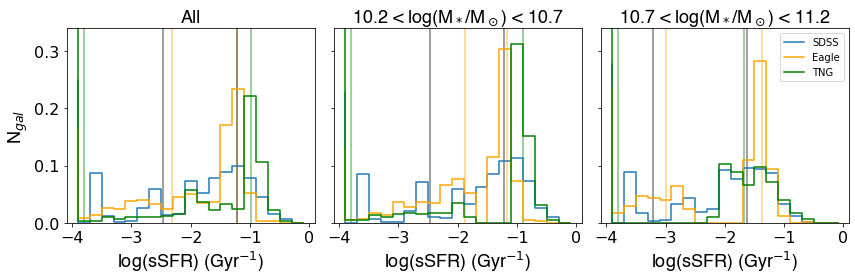

In [82]:
fig, ax = plt.subplots(ncols=3,sharex=True,sharey=True, figsize=(12,4))
hist1, bins1 = np.histogram(sdss['ssfr'][sdss['logMass'] > 10.7], bins=20, range=(-4,0))
hist2, bins2 = np.histogram(eag_high[:,3]+9, bins=20, range=(-4,0))
hist3, bins3 = np.histogram(tng_high[:,3]+9, bins=20, range=(-4,0))
plt.step((bins1[1:]+bins1[:-1])/2., hist1/sum(hist1), label='SDSS')
plt.step((bins1[1:]+bins2[:-1])/2., hist2/sum(hist2), label='Eagle', color='orange')
plt.step((bins1[1:]+bins3[:-1])/2., hist3/sum(hist3), label='TNG', color='green')
hist1, bins1 = np.histogram(sdss['ssfr'][sdss['logMass'] < 10.7], bins=20, range=(-4,0))
hist2, bins2 = np.histogram(eag_low[:,3]+9, bins=20, range=(-4,0))
hist3, bins3 = np.histogram(tng_low[:,3]+9, bins=20, range=(-4,0))
ax[1].step((bins1[1:]+bins1[:-1])/2., hist1/sum(hist1), label='SDSS')
ax[1].step((bins1[1:]+bins2[:-1])/2., hist2/sum(hist2), label='Eagle', color='orange')
ax[1].step((bins1[1:]+bins3[:-1])/2., hist3/sum(hist3), label='TNG', color='green')

hist1, bins1 = np.histogram(sdss['ssfr'], bins=20, range=(-4,0))
hist2, bins2 = np.histogram(np.concatenate((eag_low[:,3],eag_high[:,3]))+9, bins=20, range=(-4,0))
hist3, bins3 = np.histogram(np.concatenate((tng_low[:,3],tng_high[:,3]))+9, bins=20, range=(-4,0))
ax[0].step((bins1[1:]+bins1[:-1])/2., hist1/sum(hist1), label='SDSS')
ax[0].step((bins1[1:]+bins2[:-1])/2., hist2/sum(hist2), label='Eagle', color='orange')
ax[0].step((bins1[1:]+bins3[:-1])/2., hist3/sum(hist3), label='TNG', color='green')

plt.legend()
def cutoffs(ssfr):
    inds = np.argsort(ssfr)
    return ssfr[inds[int(len(ssfr)/3)]], ssfr[inds[int(2*len(ssfr)/3)]]
tlq, tlsf = cutoffs(tng_low[:,3]+9)
elq, elsf = cutoffs(eag_low[:,3]+9)
thq, thsf = cutoffs(tng_high[:,3]+9)
ehq, ehsf = cutoffs(eag_high[:,3]+9)
slq, slsf = cutoffs(sdss['ssfr'][sdss['logMass'] < 10.7] )
shq, shsf = cutoffs(sdss['ssfr'][sdss['logMass'] > 10.7] )
taq, tasf = cutoffs(np.concatenate((tng_low[:,3],tng_high[:,3]))+9)
eaq, easf = cutoffs(np.concatenate((eag_low[:,3],eag_high[:,3]))+9)
saq, sasf = cutoffs(sdss['ssfr'][sdss['logMass'] < 10.7] )
ax[0].vlines(taq + 0.2, 0, 400, color='green', alpha=0.5)
ax[0].vlines(eaq + 0.2, 0, 400, color='orange', alpha=0.5)
ax[0].vlines(saq + 0.2, 0, 400, color='k', alpha=0.5)
ax[0].vlines(tasf, 0, 400, color='green', alpha=0.5)
ax[0].vlines(easf, 0, 400, color='orange', alpha=0.5)
ax[0].vlines(sasf, 0, 400, color='k', alpha=0.5)
ax[1].vlines(tlq + 0.2, 0, 400, color='green', alpha=0.5)
ax[1].vlines(elq + 0.2, 0, 400, color='orange', alpha=0.5)
ax[1].vlines(slq + 0.2, 0, 400, color='k', alpha=0.5)
ax[1].vlines(tlsf, 0, 400, color='green', alpha=0.5)
ax[1].vlines(elsf, 0, 400, color='orange', alpha=0.5)
ax[1].vlines(slsf, 0, 400, color='k', alpha=0.5)
ax[2].vlines(thq + 0.2, 0, 400, color='green', alpha=0.5)
ax[2].vlines(ehq + 0.2, 0, 400, color='orange', alpha=0.5)
ax[2].vlines(shq + 0.2, 0, 400, color='k', alpha=0.5)
ax[2].vlines(thsf, 0, 400, color='green', alpha=0.5)
ax[2].vlines(ehsf, 0, 400, color='orange', alpha=0.5)
ax[2].vlines(shsf, 0, 400, color='k', alpha=0.5)
plt.ylim(0,.34)
ax[0].set_xlabel(r'log(sSFR) (Gyr$^{-1}$)', fontsize=16, font=font)
ax[1].set_xlabel(r'log(sSFR) (Gyr$^{-1}$)',fontsize=16, font=font)
ax[2].set_xlabel(r'log(sSFR) (Gyr$^{-1}$)',fontsize=16, font=font)
ax[0].set_ylabel(r'N$_{gal}$',fontsize=16, font=font)
# print(tng_ssfr.min(), tng_ssfr.max(), eag_ssfr.min(), eag_ssfr.max())
ax[0].set_title('All', fontsize=14,font=font)
ax[1].set_title(r'10.2 < log(M$_*$/M$_\odot$) < 10.7', fontsize=14,font=font)
ax[2].set_title(r'10.7 < log(M$_*$/M$_\odot$) < 11.2', fontsize=14,font=font)
plt.tight_layout()
plt.savefig('../ssfr-hists.png')

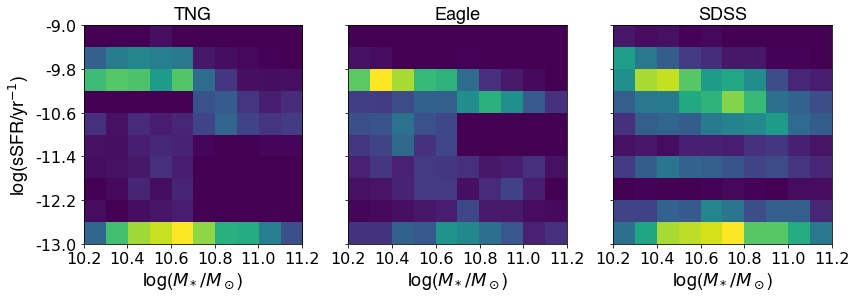

In [70]:
tnghist, xedges1, yedges1 = np.histogram2d(np.concatenate((tng_low[:,3], tng_high[:,3])), 
                                           np.concatenate((tng_low[:,2], tng_high[:,2])), range=((-13,-9),(10.2,11.2)))
eaghist, xedges2, yedges2 = np.histogram2d(np.concatenate((eag_low[:,3], eag_high[:,3])), 
                                           np.concatenate((eag_low[:,2], eag_high[:,2])), range=((-13,-9),(10.2,11.2)))
obshist, xedges3, yedges3 = np.histogram2d(sdss['ssfr']-9, sdss['logMass'], range=((-13,-9),(10.2,11.2)))
fig, ax = plt.subplots(ncols=3, sharex=True, sharey=True, figsize=(12,4))
# ax[0].contour(tnghist, extent=[xedges1[0],xedges1[-1],yedges1[0],yedges1[-1]])
# ax[1].contour(eaghist, extent=[xedges2[0],xedges2[-1],yedges2[0],yedges2[-1]])
# ax[2].contour(obshist, extent=[xedges3[0],xedges3[-1],yedges3[0],yedges3[-1]])
ax[0].imshow(tnghist, cmap=cm.viridis, norm=colors.Normalize(tnghist.min(), tnghist.max()))
ax[1].imshow(eaghist, cmap=cm.viridis, norm=colors.Normalize(eaghist.min(), eaghist.max()))
ax[2].imshow(obshist, cmap=cm.viridis, norm=colors.Normalize(obshist.min(), obshist.max()), origin='lower')
ax[0].set_title('TNG', fontsize=16, font=font)
ax[1].set_title('Eagle', fontsize=16, font=font)
ax[2].set_title('SDSS', fontsize=16, font=font)
xedges = [yedges1,yedges2,yedges3]
for i in range(3):
    ax[i].set_xlabel(r'log($M_*/M_\odot$)', fontsize=16, font=font)
    ax[i].set_xticks(np.arange(len(yedges1))[::2]-0.5)
    ax[i].set_xticklabels(['%0.1f' % x for x in xedges[i][::2]])
ax[0].set_yticks(np.arange(len(xedges1))[::2]-.5)
ax[0].set_yticklabels(['%0.1f' % x for x in xedges1[::2]])
ax[0].set_ylabel(r'log(sSFR/yr$^{-1}$)', fontsize=16, font=font)
plt.tight_layout()
plt.savefig('../mstar-ssfr-hist.png')

In [176]:
from scipy.optimize import curve_fit
from scipy.integrate import quad

path='../' #/data/gnarming/uchadaya/eFEDS/ if on hea comp
cdf = np.mean(np.mean(fits.getdata(path+'psf1.fits'), axis=1), axis=1)
eef = np.arange(0.4, 1.0, 0.05)
sb = eef/(np.pi*cdf**2)
area = np.pi * (cdf[1:]**2 - cdf[:-1]**2)
dE = eef[1:] - eef[:-1]
sb[1:] = dE / area
sb /= sb[0]
xcdf = (cdf[1:] + cdf[:-1])/2
xcdf = np.insert(xcdf,0,cdf[0]/2)
xcdf *= (4 * 1.45)

# print(xcdf, eef, sb)
def psf_curve(r, A, rs, beta):
	return A * (1 + (r/rs)**2)**(-beta) #Moffat function, beta=2.0 fitted for XMM

def psf_area(r, A, rs, beta): 
	#integrating this from r1 to r2 should give me the fraction of photons enclosed between those radii
		#IF THE PSF IS PROPERLY NORMALISED
		#in other words, integrating this gives the factor that the raw PSF should be normalised by. 
	return 2*np.pi*r * psf_curve(r, A, rs, beta) #

fit, _ =  curve_fit(psf_curve, xcdf, sb)
area_psf, _ = quad(psf_area, args=(fit[0],fit[1], fit[2]), a=0, b=np.infty) 
xp = np.arange(0,100,.1)
yp = psf_curve(xp, *fit)/area_psf


def Lxrb(sdss, low=False, high=False, model = 'Lehmer19', nobeta=False):  #alpha in erg/s/Msun, beta in erg/s/Msun/yr)
    theta = 1 #power law SFR
    delta = 0 #no redshift dependence 
    beta_ism = 8.3e38 #Mineo+ 2012b #why does Lehmer 16 quote it as 1.5e39?? barely works if they converted it to 0.5-8. 
    if model =='Lehmer19':
    #their values are for 0.5-8keV. PIMMS, power law using photon index = 1.7
        alpha = .397*pow(10,29.15)
        beta = .397*pow(10,39.73)
        if low:
            alpha = .397*pow(10,29.09)
            beta = .397*pow(10,39.61)
        if high:
            alpha = .397*pow(10,29.21)
            beta = .397*pow(10,39.85)
    elif model == 'Lehmer10':
        alpha = 0.347*9.05e28 
        beta = 0.347*1.62e39
        if low:
            alpha -= 0.37e28
            beta -= 0.22e39
        if high:
            alpha += 0.37e28
            beta += 0.22e39
    elif model == 'Lehmer16':
        #https://ui.adsabs.harvard.edu/abs/2016ApJ...825....7L/abstract
        #quoted for .5-2keV, hallelujah!
        alpha = pow(10,28.87)# ± 0.24
        beta = pow(10,39.66)# ± 0.17
        if high:
            alpha = pow(10,29.11)# ± 0.24
            beta = pow(10,39.83)
        if low:
            alpha = pow(10,28.63)# ± 0.24
            beta = pow(10,39.49)
    elif model == 'Aird2017':
        #https://ui.adsabs.harvard.edu/abs/2017MNRAS.465.3390A/abstract
        #2-10 keV Lx, spectral index 1.9
        #so conversion factor to 0.5-2 keV = 0.741
        alpha = .741*pow(10,28.81) # ± 0.08
        beta = .741*pow(10,39.50) # ± 0.06
        if low:
            alpha = .741*pow(10,28.73) 
            beta = .741*pow(10,39.44) 
        if high:
            alpha = .741*pow(10,28.89)
            beta = .741*pow(10,39.56) 
        theta = 0.86
        delta = 3.9
    elif model == 'Fornasini2018':
        #https://ui.adsabs.harvard.edu/abs/2018ApJ...865...43F/abstract
        #also 2-10kev band photon index 1.4
        alpha = .347*pow(10,29.98)# ± 0.12
        beta = .347*pow(10,39.78)# ± 0.12
        theta = 0.84
        if low:
            alpha = .347*pow(10,29.86)
            beta = .347*pow(10,39.66)
        if high:
            alpha = .347*pow(10,30.10)
            beta = .347*pow(10,39.90)
#     print(alpha, beta)
    mstar = 10**sdss['logMass']
    sfr = 10**(sdss['ssfr'] - 9) * mstar #the -9 converts from Msun/Gyr to Msun/yr
    if nobeta:
        return alpha*mstar 
    else: 
        return alpha*mstar + (beta+beta_ism)*(sfr**theta)*((1+sdss['z'])**delta)
 

(0.01, 1)

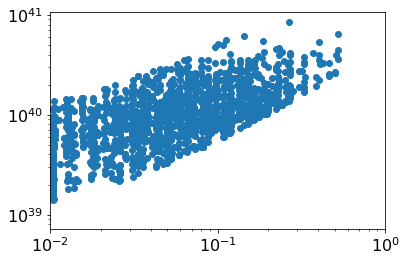

In [556]:
plt.scatter(10**sdss['ssfr'], Lxrb(sdss))
plt.yscale('log'); plt.xscale('log')
plt.xlim(.01,1)

In [142]:
def xrb_psf(sdss, model = 'Lehmer19', nobeta=False, fit=fit, area_psf=area_psf):
		norm = Lxrb(sdss,model = model, nobeta=nobeta).mean()
		xp = np.arange(0,100,.1)
		yp = psf_curve(xp, *fit)/area_psf
		return xp, yp,norm

(5.5, 100)

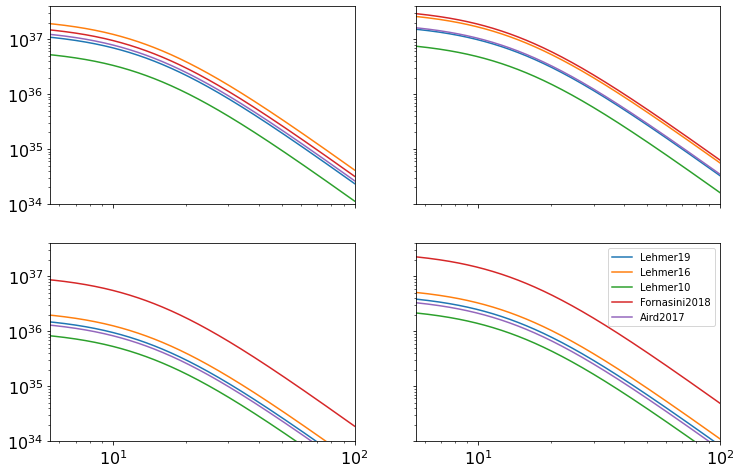

In [172]:
fig, ax = plt.subplots(ncols=2, nrows=2, sharex=True, sharey=True, figsize=(12,8))
model = ['Lehmer19','Lehmer16', 'Lehmer10', 'Fornasini2018', 'Aird2017']
for i in range(5):
    xp, yp, norm1 = xrb_psf(src[high].iloc[highsf], model=model[i])
    xp, yp, norm2 = xrb_psf(src[high].iloc[highq], model=model[i])
    xp, yp, norm3 = xrb_psf(src[low].iloc[lowsf], model=model[i])
    xp, yp, norm4 = xrb_psf(src[low].iloc[lowq], model=model[i])
    ax.flatten()[1].loglog(xp, yp*norm1)
    ax.flatten()[3].loglog(xp, yp*norm2, label=model[i])
    ax.flatten()[0].loglog(xp, yp*norm3)
    ax.flatten()[2].loglog(xp, yp*norm4)
    
plt.legend()
plt.ylim(1e34,4e37)
plt.xlim(5.5,100)

In [22]:
high = gals['logMass'] > 10.7
highsf, highq = sort(gals[high])
xp, yp, norm = xrb_psf(gals[high][highsf], beta=1.62e39)
fit_xrb     = fit[0]*norm/area_psf
quad(psf_area, a=0, b=np.inf,args=(fit_xrb, fit[1], fit[2])), norm 

((1.483519644838377e+40, 1.862620903607348e+32), 1.4835196448383773e+40)

In [87]:
prof0520 = pd.read_csv('../src_broad_0520.csv')
prof0510 = pd.read_csv('../src_broad_0510.csv')
prof0520 = prof0520[(prof0520['logMass'] > 10.2)*(prof0520['logMass'] < 11.2)]
prof0510 = prof0520[(prof0510['logMass'] > 10.2)*(prof0510['logMass'] < 11.2)]
ar = prof0520['area-0-5.5']+prof0520['area-5.5-10']
print((prof0520['bck-area'][ar>0]/ar[ar>0]).mean())
#this makes sense 

134.17764976183068


<ipython-input-87-d61ffc4e4bbc>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prof0510 = prof0520[(prof0510['logMass'] > 10.2)*(prof0510['logMass'] < 11.2)]


So see, the integral does indeed yield the total luminosity between a and b

In [200]:
 def sb_prof(tab, model = 'Lehmer19', nobeta=False, xrb=False, 
             cts_to_erg=1.624e-12, debug=False, tot=False, rcore = 10, mincts=-1e5, bkg_scale=1, bck='bck-'):
        rs = ['0-5.5','5.5-10','10-20','20-40','40-60','60-100']
        sb_err = np.zeros((len(rs), 4))
        dl2 = 4*np.pi*(lcdm.luminosity_distance(tab['z']).to('cm'))**2
        dA2 = (lcdm.angular_diameter_distance(tab['z']).to('kpc')*u.arcsec.to('radian'))**2
        if tot:
            cts_tot = 0
            net_cts_tot = 0
            lx_tot = 0
        for i in range(len(rs)):
            """read parameters"""
            rmin = float(rs[i].split('-')[0])
            rmax = float(rs[i].split('-')[1])
            sb_err[i,0] = rmin
            sb_err[i,1] = rmax
            cts = tab['cts-'+rs[i]]
            area = tab['area-'+rs[i]]
            exp = tab['exp-'+rs[i]]
            """correct for background"""
            if np.nansum(area) and np.nansum(exp):
                if bck == 'bck-':
                    bkg_rt = tab['bck-cts']/(tab['bck-area']*tab['bck-exp'])
                elif bck=='all':
                    bkg_rt = (tab['150-250-cts']+tab['bck-cts'])/((tab['150-250-area']+tab['bck-area'])
                                                                  *((tab['150-250-exp']+tab['bck-exp'])/2.))
                else:
                    bkg_rt = tab['150-250-cts']/(tab['150-250-area']*tab['150-250-exp'])
                bkg_rt = np.nanmedian(bkg_rt[bkg_rt>-10])
                bkg_rt *= bkg_scale
                if debug and not rmin: 
                    print(bkg_rt*cts_to_erg*dl2.mean())
                net_cts = cts - bkg_rt*area*exp

                """remove XRB contribution"""
                if xrb: #CHECK THESE LINES
                    xp, yp, norm = xrb_psf(tab, model = model, nobeta=nobeta) # XRB SB profile
                    rmean = (rmin+rmax)/2. # value at central radius of this bin
                    ind = np.argmin(abs(xp - rmean))
                    lxrb = yp[ind]*norm*area*dA2 # Lx(XRB) = SB * area(kpc**2)
                    xrb_cts = lxrb*exp/(cts_to_erg * dl2.value) # erg/s * exp(s) / (cts_to_ergs/cm**2 * cm**2)
                    net_cts -= xrb_cts 
                    if debug:
                        print(rmin, '-', rmax,' :', np.nansum(cts), np.nansum(net_cts+xrb_cts), np.nansum(net_cts), np.nansum(xrb_cts))
                
                """convert net counts to SB"""
                sb_err[i,2] = np.nansum((net_cts * dl2.value))/(np.nanmean(area*dA2)*np.nansum(exp)) * cts_to_erg 
                """compute error bars"""
                sb_err[i,3] = np.sqrt(np.nansum(cts))/np.nansum(net_cts)
                """integrate SB to get luminosity"""
                if tot:
                    if rmin >= rcore:
                        if np.nansum(net_cts) > mincts:
                            cts_tot += np.nansum(cts)
                            net_cts_tot += np.nansum(net_cts)
                            lx_tot += np.nansum(net_cts* dl2.value)* cts_to_erg 
        if tot:
            lx_tot /= np.nansum(exp) 
            err_tot = np.sqrt(np.nansum(cts_tot))/np.nansum(net_cts_tot)
            return lx_tot, err_tot
        else:
            return sb_err

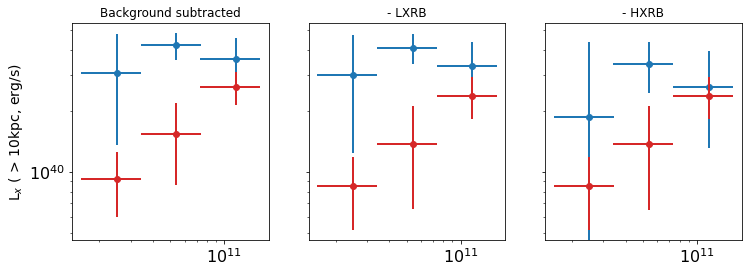

In [258]:
def Lx_err_allmodels(sub, models, backgrounds, Lx_xrb, err_xrb, i,nobeta,xrb,rcore):
    Lx_sf = np.zeros((len(models), len(backgrounds)))
    Lx_q = np.zeros((len(models), len(backgrounds)))
    err_sf = np.zeros((len(models), len(backgrounds)))
    err_q = np.zeros((len(models), len(backgrounds)))
    for j, model in enumerate(models):
        for k, bck in enumerate(backgrounds):
            Lx_sf[j, k], err_sf[j, k] = sb_prof(sub.iloc[sf], model = model, nobeta=nobeta, xrb=xrb, tot=True, rcore = rcore, mincts=-10, bck=bck)
            Lx_q[j, k], err_q[j, k] = sb_prof(sub.iloc[q], model = model, nobeta=nobeta, xrb=xrb, tot=True, rcore = rcore, mincts=-10, bck=bck)
    Lx_xrb[0,i] = (np.nanmax((1+err_sf)*Lx_sf) + np.nanmin((1-err_sf)*Lx_sf))/2.
    Lx_xrb[1,i] = (np.nanmax((1+err_q)*Lx_q) + np.nanmin((1-err_q)*Lx_q))/2.
    err_xrb[0,i] = (np.nanmax((1+err_sf)*Lx_sf) - np.nanmin((1-err_sf)*Lx_sf))/2.
    err_xrb[1,i] = (np.nanmax((1+err_q)*Lx_q) - np.nanmin((1-err_q)*Lx_q))/2.
    
src = prof0520
Mleft = np.linspace(10.2, 10.867, 3)
Mright = Mleft + 0.334
M = (10**Mleft + 10**Mright)/2.
dM = (10**Mright - 10**Mleft)/2.
Lx_raw = np.zeros((2,3)); err_xrb = np.zeros((2,3))
Lx_lxrb = np.zeros((2,3)); err_xrb = np.zeros((2,3))
Lx_xrb = np.zeros((2,3)); err_xrb = np.zeros((2,3))
fig, ax = plt.subplots(ncols=3, sharex=True, sharey=True, figsize=(12,4))
xrb_models = ['Lehmer19','Lehmer10','Aird2017']#'Lehmer16','Fornasini2018']
backgrounds = ['bck-','all','150-']
for i in range(3):
    sub = src[(src['logMass'] > Mleft[i])*(src['logMass'] < Mright[i])]
    sf, q = sort(sub)
    Lx_err_allmodels(sub, xrb_models, backgrounds, Lx_raw, err_raw, i,nobeta=False,xrb=False,rcore=10)
    Lx_err_allmodels(sub, xrb_models, backgrounds, Lx_lxrb, err_lxrb, i,nobeta=True,xrb=True,rcore=10)
    Lx_err_allmodels(sub, xrb_models, backgrounds, Lx_xrb, err_xrb, i,nobeta=False,xrb=True,rcore=10)
ax[0].errorbar(M, Lx_raw[0], color='tab:blue', xerr=dM, yerr=err_raw[0], linewidth=0, elinewidth=2)
ax[1].errorbar(M, Lx_lxrb[0], color='tab:blue', xerr=dM, yerr=err_lxrb[0], linewidth=0, elinewidth=2)
ax[2].errorbar(M, Lx_xrb[0], color='tab:blue', xerr=dM, yerr=err_xrb[0], linewidth=0, elinewidth=2)
ax[0].errorbar(M, Lx_raw[1], color='tab:red', xerr=dM, yerr=err_raw[1], linewidth=0, elinewidth=2)
ax[1].errorbar(M, Lx_lxrb[1], color='tab:red', xerr=dM, yerr=err_lxrb[1], linewidth=0, elinewidth=2)
ax[2].errorbar(M, Lx_xrb[1], color='tab:red', xerr=dM, yerr=err_xrb[1], linewidth=0, elinewidth=2)
ax[0].scatter(M, Lx_raw[0], color='tab:blue')
ax[1].scatter(M, Lx_lxrb[0], color='tab:blue')
ax[2].scatter(M, Lx_xrb[0], color='tab:blue')
ax[0].scatter(M, Lx_raw[1], color='tab:red')
ax[1].scatter(M, Lx_lxrb[1], color='tab:red')
ax[2].scatter(M, Lx_xrb[1], color='tab:red')
ax[0].set_title('Background subtracted')
ax[1].set_title('- LXRB')
ax[2].set_title('- HXRB')
ax[0].set_ylabel(r'L$_x$ ( > 10kpc, erg/s)', fontsize=14)
plt.yscale('log'); plt.xscale('log')

#this plot really depends on the choice of background as well as XRB model
#i think the correct approach is to compute all of them and show the limits as errorbars.

Text(0, 0.5, 'L$_x$ (erg/s)')

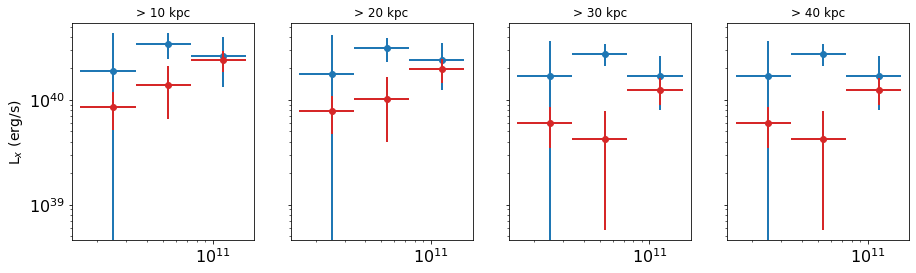

In [260]:
Lx_20 = np.zeros((2,3)); err_20 = np.zeros((2,3))
Lx_30 = np.zeros((2,3)); err_30 = np.zeros((2,3))
Lx_40 = np.zeros((2,3)); err_40 = np.zeros((2,3))
fig, ax = plt.subplots(ncols=4, sharex=True, sharey=True, figsize=(15,4))
for i in range(3):
    sub = src[(src['logMass'] > Mleft[i])*(src['logMass'] < Mright[i])]
    sf, q = sort(sub)
    Lx_err_allmodels(sub, xrb_models, backgrounds, Lx_20, err_20, i,nobeta=False,xrb=True,rcore=20)
    Lx_err_allmodels(sub, xrb_models, backgrounds, Lx_30, err_30, i,nobeta=False,xrb=True,rcore=30)
    Lx_err_allmodels(sub, xrb_models, backgrounds, Lx_40, err_40, i,nobeta=False,xrb=True,rcore=40)
ax[0].errorbar(M, Lx_xrb[0], color='tab:blue', xerr=dM, yerr=err_xrb[0], linewidth=0, elinewidth=2)
ax[1].errorbar(M, Lx_20[0], color='tab:blue', xerr=dM, yerr=err_20[0], linewidth=0, elinewidth=2)
ax[2].errorbar(M, Lx_30[0], color='tab:blue', xerr=dM, yerr=err_30[0], linewidth=0, elinewidth=2)
ax[3].errorbar(M, Lx_40[0], color='tab:blue', xerr=dM, yerr=err_40[0], linewidth=0, elinewidth=2)
ax[0].errorbar(M, Lx_xrb[1], color='tab:red', xerr=dM, yerr=err_xrb[1], linewidth=0, elinewidth=2)
ax[1].errorbar(M, Lx_20[1], color='tab:red', xerr=dM, yerr=err_20[1], linewidth=0, elinewidth=2)
ax[2].errorbar(M, Lx_30[1], color='tab:red', xerr=dM, yerr=err_30[1], linewidth=0, elinewidth=2)
ax[3].errorbar(M, Lx_40[1], color='tab:red', xerr=dM, yerr=err_40[1], linewidth=0, elinewidth=2)
ax[0].scatter(M, Lx_xrb[0], color='tab:blue')
ax[1].scatter(M, Lx_20[0], color='tab:blue')
ax[2].scatter(M, Lx_30[0], color='tab:blue')
ax[3].scatter(M, Lx_40[0], color='tab:blue')
ax[0].scatter(M, Lx_xrb[1], color='tab:red')
ax[1].scatter(M, Lx_20[1], color='tab:red')
ax[2].scatter(M, Lx_30[1], color='tab:red')
ax[3].scatter(M, Lx_40[1], color='tab:red')
ax[0].set_title('> 10 kpc')
ax[1].set_title('> 20 kpc')
ax[2].set_title('> 30 kpc')
ax[3].set_title('> 40 kpc')
plt.yscale('log'); plt.xscale('log')
ax[0].set_ylabel(r'L$_x$ (erg/s)', fontsize=14)
#this plot really depends on the choice of background as well as XRB model
#i think the correct approach is to compute all of them and show the limits as errorbars.

Text(0, 0.5, 'L$_x$ (erg/s)')

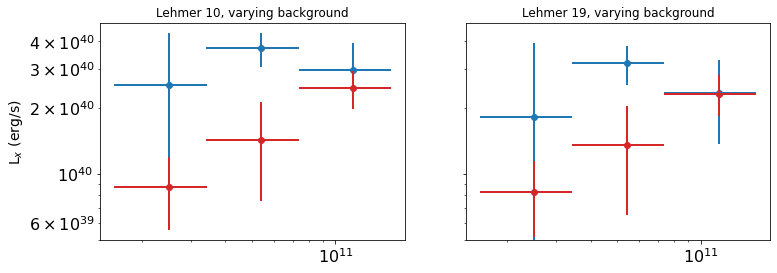

In [347]:
#effect of BKG only
Lx_xrb = np.zeros((2,3)); err_xrb = np.zeros((2,3))
Lx_l19 = np.zeros((2,3)); err_l19 = np.zeros((2,3))
fig, ax = plt.subplots(ncols=2,sharex=True, sharey=True, figsize=(12,4))
for i in range(3):
    sub = src[(src['logMass'] > Mleft[i])*(src['logMass'] < Mright[i])]
    sf, q = sort(sub)
    Lx_err_allmodels(sub, ['Lehmer10'], backgrounds, Lx_xrb, err_xrb, i,nobeta=False,xrb=True,rcore=10)
    Lx_err_allmodels(sub, ['Lehmer19'], backgrounds, Lx_l19, err_l19, i,nobeta=False,xrb=True,rcore=10)
ax[0].errorbar(M, Lx_xrb[0], color='tab:blue', xerr=dM, yerr=err_xrb[0], linewidth=0, elinewidth=2)
ax[0].errorbar(M, Lx_xrb[1], color='tab:red', xerr=dM, yerr=err_xrb[1], linewidth=0, elinewidth=2)
ax[0].scatter(M, Lx_xrb[0], color='tab:blue')
ax[0].scatter(M, Lx_xrb[1], color='tab:red')
plt.errorbar(M, Lx_l19[0], color='tab:blue', xerr=dM, yerr=err_l19[0], linewidth=0, elinewidth=2)
plt.errorbar(M, Lx_l19[1], color='tab:red', xerr=dM, yerr=err_l19[1], linewidth=0, elinewidth=2)
plt.scatter(M, Lx_l19[0], color='tab:blue')
plt.scatter(M, Lx_l19[1], color='tab:red')
ax[0].set_title('Lehmer 10, varying background')
plt.title('Lehmer 19, varying background')
plt.yscale('log'); plt.xscale('log')
ax[0].set_ylabel(r'L$_x$ (erg/s)', fontsize=14)
#this plot really depends on the choice of background as well as XRB model
#i think the correct approach is to compute all of them and show the limits as errorbars.

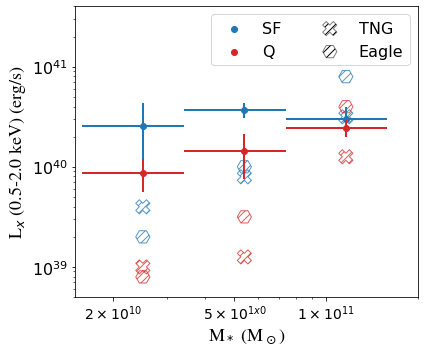

In [348]:
eag_q = 10**np.array([38.9,39.5,40.6]) #  mean low-sSFR #257, 170, 71
eag_sf =  10**np.array([39.3,40.0,40.9]) # mean high-sSFR

tng_q = 10**np.array([39.0,39.1,40.1]) # mean low-sSFR #348, 347, 144
tng_sf = 10**np.array([39.6,39.9,40.5]) # mean high-sSFR

fig, ax = plt.subplots(ncols = 1, figsize=(6,5))
gals = prof0520 #cut
Mleft = np.linspace(10.2, 10.867, 3)
Mright = Mleft + 0.334
M = (10**Mleft + 10**Mright)/2.
dM = (10**Mright - 10**Mleft)/2.
ax.errorbar(M, Lx_xrb[0], xerr=dM, yerr=err_xrb[0], color='tab:blue', linewidth=0, elinewidth=2)
ax.scatter(M, Lx_xrb[0], color='tab:blue', label='SF')
ax.errorbar(M, Lx_xrb[1], xerr=dM, yerr=err_xrb[1], color='tab:red', linewidth=0, elinewidth=2)
ax.scatter(M, Lx_xrb[1], color='tab:red', label='Q')
ax.scatter(M, tng_sf, color='None',edgecolors='tab:blue', marker='X', s=200, alpha=0.75, hatch='///')
ax.scatter(M, eag_sf, color='None',edgecolors='tab:blue', marker='H', s=200, alpha=0.75, hatch='///')
ax.scatter(M, tng_q, color='None',edgecolors='tab:red', marker='X', s=200, alpha=0.75, hatch='///')
ax.scatter(M, eag_q, color='None',edgecolors='tab:red', marker='H', s=200, alpha=0.75, hatch='///')
ax.scatter(1, 1, color='None',edgecolors='k', marker='X', s=200, alpha=0.5, label='TNG', hatch='///')
ax.scatter(1, 1, color='None',edgecolors='k', marker='H', s=200, alpha=0.5, label='Eagle', hatch='///')
#       
ax.legend(fontsize=16,ncol=2)
ax.set_ylim(5e38, 4e41)
ax.set_xlim(1.5e10,2e11)
plt.yscale('log'); plt.xscale('log')
ax.set_xticks([2e10,5e10,1e11])
ax.set_xticklabels([r'$2\times10^{10}$',r'$5\times10^{1x0}$',r'$1\times10^{11}$'], fontsize=14)
ax.set_xlabel(r'M$_*$ (M$_\odot$)', fontfamily='STIXGeneral', fontsize=18)
ax.set_ylabel(r'L$_x$ (0.5-2.0 keV) (erg/s)', fontfamily='STIXGeneral', fontsize=18)
plt.tight_layout()
plt.savefig('../Lx-Mstar-obs.png',dpi=156)

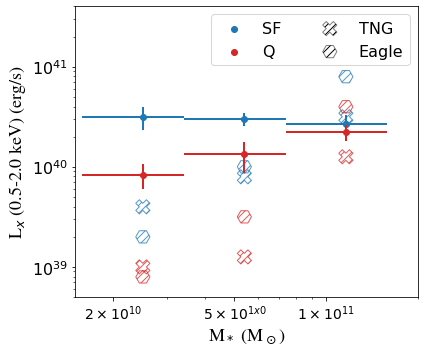

In [224]:
#old values
eag_q = 10**np.array([38.9,39.5,40.6]) #  mean low-sSFR #257, 170, 71
eag_sf =  10**np.array([39.3,40.0,40.9]) # mean high-sSFR

tng_q = 10**np.array([39.0,39.1,40.1]) # mean low-sSFR #348, 347, 144
tng_sf = 10**np.array([39.6,39.9,40.5]) # mean high-sSFR

fig, ax = plt.subplots(ncols = 1, figsize=(6,5))
gals = prof0520 #cut
Mleft = np.linspace(10.2, 10.867, 3)
Mright = Mleft + 0.334
M = (10**Mleft + 10**Mright)/2.
dM = (10**Mright - 10**Mleft)/2.
ax.errorbar(M, Lx_xrb[0], xerr=dM, yerr=err_xrb[0]*Lx_xrb[0], color='tab:blue', linewidth=0, elinewidth=2)
ax.scatter(M, Lx_xrb[0], color='tab:blue', label='SF')
ax.errorbar(M, Lx_xrb[1], xerr=dM, yerr=err_xrb[1]*Lx_xrb[1], color='tab:red', linewidth=0, elinewidth=2)
ax.scatter(M, Lx_xrb[1], color='tab:red', label='Q')
ax.scatter(M, tng_sf, color='None',edgecolors='tab:blue', marker='X', s=200, alpha=0.75, hatch='///')
ax.scatter(M, eag_sf, color='None',edgecolors='tab:blue', marker='H', s=200, alpha=0.75, hatch='///')
ax.scatter(M, tng_q, color='None',edgecolors='tab:red', marker='X', s=200, alpha=0.75, hatch='///')
ax.scatter(M, eag_q, color='None',edgecolors='tab:red', marker='H', s=200, alpha=0.75, hatch='///')
ax.scatter(1, 1, color='None',edgecolors='k', marker='X', s=200, alpha=0.5, label='TNG', hatch='///')
ax.scatter(1, 1, color='None',edgecolors='k', marker='H', s=200, alpha=0.5, label='Eagle', hatch='///')
#       
ax.legend(fontsize=16,ncol=2)
ax.set_ylim(5e38, 4e41)
ax.set_xlim(1.5e10,2e11)
plt.yscale('log'); plt.xscale('log')
ax.set_xticks([2e10,5e10,1e11])
ax.set_xticklabels([r'$2\times10^{10}$',r'$5\times10^{1x0}$',r'$1\times10^{11}$'], fontsize=14)
ax.set_xlabel(r'M$_*$ (M$_\odot$)', fontfamily='STIXGeneral', fontsize=18)
ax.set_ylabel(r'L$_x$ (0.5-2.0 keV) (erg/s)', fontfamily='STIXGeneral', fontsize=18)
plt.tight_layout()
plt.savefig('../Lx-Mstar-obs.png',dpi=156)

In [89]:
def sb_bkg(tab, bck='bck-'):
    cts_to_erg = 1.624e-12
    dl2 = 4*np.pi*lcdm.angular_diameter_distance(tab['z']).to('cm')**2
    if bck == 'bck-':
        return np.nanmedian(tab['bck-cts']/(tab['bck-area']*tab['bck-exp'])) *dl2.mean() * cts_to_erg
    else:
        return np.nanmedian(tab['150-250-cts']/(tab['150-250-area']*tab['150-250-exp'])) *dl2.mean() * cts_to_erg

In [90]:
def plot(sb_err, ax, color, nsigma=1, alpha=1, lw=2, bkg=0,marker='v'):
    x = (sb_err[:,0] + sb_err[:,1])/2.
    xerr = (sb_err[:,0] - sb_err[:,1])/2.
    sb = sb_err[:,2]
    err = sb_err[:,3]
    valid = (sb > 0)*(err < 1)
    confident = (sb > bkg)
    iffy = (sb < bkg)
    ax.errorbar(x[valid*confident], sb[valid*confident], xerr=xerr[valid*confident], yerr=(sb*err)[valid*confident], color=color, alpha=alpha, linewidth=0, elinewidth=lw)
    ax.scatter(x[valid*confident], sb[valid*confident], s=50, color=color, alpha=alpha)
    ax.errorbar(x[valid*iffy], sb[valid*iffy], xerr=xerr[valid*iffy], yerr=(sb*err)[valid*iffy], color=color, alpha=alpha/2., linewidth=0, elinewidth=lw)
    ax.scatter(x[valid*iffy], sb[valid*iffy], s=50, color=color, alpha=alpha/2.)
    ax.scatter(x[~valid], sb[~valid], color=color, marker=marker, alpha=alpha, s=50)
    ax.vlines(x[~valid], sb[~valid], sb[~valid]*(1+nsigma*err[~valid]), color=color, alpha=alpha)
    ax.errorbar(x[~valid], sb[~valid], xerr=xerr[~valid], yerr=None, color=color, alpha=alpha, linewidth=0, elinewidth=lw)


In [123]:
def plot_sim_profiles(sb_bkg, sdss, ax, simsfile = 'BenData/SBprof_disp.EAGLE_TNG.Ms10.20_10.70fixed.sSFR.docalc.20.list.SB_stats.out', 
                      cts_to_erg = 1.624e-12,color='tab:blue', ls='solid',bckcols=1, xrb=False, model = 'Lehmer19', 
                      y=True, q=True, sf=True,alpha=0.3, label=False, nobeta=False):

	ax.hlines(sb_bkg, 0,200, color='k', alpha=0.25)
	ax.hlines(0.05*sb_bkg, 0,200, color='k', alpha=0.25, linestyle='dotted')
	
	if simsfile:
		sims = np.genfromtxt(simsfile)
		yconv=3.1e39/3.44
		if sf:
			ax.fill_between(sims[:,0],sims[:,2]*yconv,sims[:,3]*yconv,color='tab:orange',alpha=alpha, label='EAGLE')
			ax.fill_between(sims[:,0],sims[:,8]*yconv,sims[:,9]*yconv,color='forestgreen',alpha=alpha, label='TNG')
		if q:
			ax.fill_between(sims[:,0],sims[:,5]*yconv,sims[:,6]*yconv,color='tab:orange',alpha=alpha, label='EAGLE')
			ax.fill_between(sims[:,0],sims[:,-2]*yconv,sims[:,-1]*yconv,color='forestgreen',alpha=alpha, label='TNG')
		format_plot(ax, y=y)
		if label:
			ax.legend(loc='best')    

	if xrb:
		xp, yp, norm = xrb_psf(sdss, model = model, nobeta=nobeta)
		sbxrb = yp*norm
		ax.plot(xp, sbxrb, c='k', label=r'XRB $\times$ PSF', linestyle=ls, alpha=0.5)

In [92]:
def format_plot(ax, yconv=3.1e39,y=True):
	ax.set_xlabel('R (kpc)', fontsize=14)
	ax.set_xlim(5.5,100)
	ax.set_xscale('log')
	ax.set_yscale('log')
	ax.set_ylim(3e33, 4e37)
	if y:
		ax.set_ylabel(r'$\Sigma_X$ (erg/s/kpc$^2$)',fontsize=14)
	for y in ax.get_yticklabels(): 
		y.set_fontfamily('STIXGeneral')
		y.set_fontsize(14)
	for x in ax.get_xticklabels(): 
		x.set_fontfamily('STIXGeneral')
		x.set_fontsize(14)
	plt.tight_layout()


In [188]:
def dl2_da2(src):
    da2 = lcdm.luminosity_distance(src['z']).to('cm')**2
    dl2 = lcdm.angular_diameter_distance(src['z']).to('cm')**2
    return dl2/da2
# print(np.mean(lcdm.angular_diameter_distance(src[high].iloc[highq]['z']).to('kpc')*u.arcsec.to('radian'))**2)
print(dl2_da2(src[high].iloc[highsf]).mean())
print(dl2_da2(src[high].iloc[highq]).mean())
print(dl2_da2(src[low].iloc[lowsf]).mean())
print(dl2_da2(src[low].iloc[lowq]).mean())

0.7438679499235258
0.7493176374442393
0.7449793056312308
0.7550571149540698


HXMB
[[0.00000000e+00 5.50000000e+00 4.03866340e+36 5.01559523e-01]
 [5.50000000e+00 1.00000000e+01 5.09535819e+36 3.95001632e-01]
 [1.00000000e+01 2.00000000e+01 2.83544127e+36 5.82502387e-01]
 [2.00000000e+01 4.00000000e+01 2.15209609e+36 5.07159633e-01]
 [4.00000000e+01 6.00000000e+01 1.54671239e+36 2.73379962e-01]
 [6.00000000e+01 1.00000000e+02 1.94179843e+35 8.59345299e-01]]


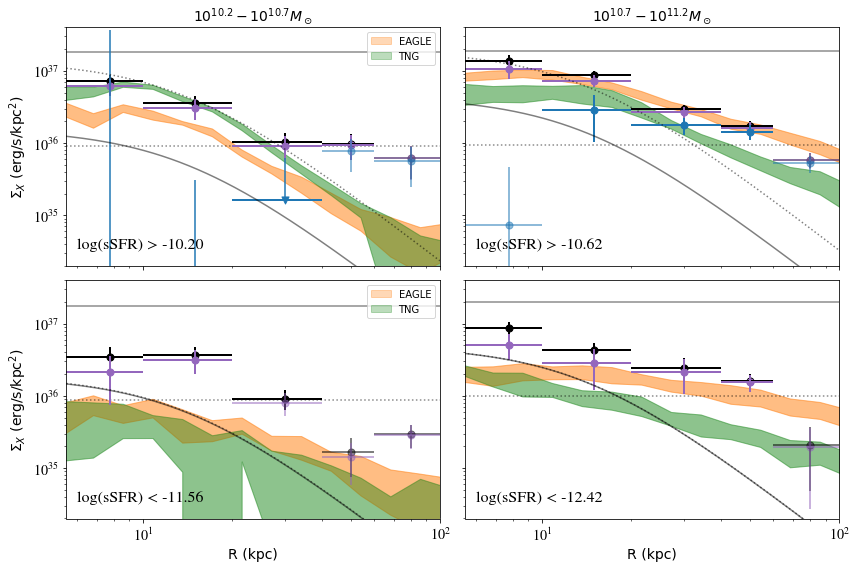

In [190]:
src = prof0520 #cut

high = src['logMass'] > 10.7
low = src['logMass'] < 10.7
highsf, highq = sort(src[high])
lowsf, lowq = sort(src[low])

# print(src[low].iloc[lowsf]['ssfr'].min(), src[low].iloc[lowq]['ssfr'].max(), 
#       src[high].iloc[highsf]['ssfr'].min(), src[high].iloc[highq]['ssfr'].max())
hsb_sf = sb_bkg(src[high].iloc[highsf]).value
hsb_q = sb_bkg(src[high].iloc[highq]).value
lsb_sf = sb_bkg(src[low].iloc[lowsf]).value
lsb_q = sb_bkg(src[low].iloc[lowq]).value
hsb_bck = sb_bkg(src[high]).value
lsb_bck = sb_bkg(src[low]).value

# print(lsb_sf, hsb_sf, lsb_q, hsb_q, lsb_bck, hsb_bck)

sb_err_high_sf_raw = sb_prof(src[high].iloc[highsf], mincts=-10, bck='all')
sb_err_high_q_raw = sb_prof(src[high].iloc[highq], mincts=-10, bck='all')
sb_err_low_sf_raw = sb_prof(src[low].iloc[lowsf], mincts=-10, bck='all')
sb_err_low_q_raw = sb_prof(src[low].iloc[lowq], mincts=-10, bck='all')

sb_err_high_sf_lxrb = sb_prof(src[high].iloc[highsf], xrb=True, nobeta=True, mincts=-10, bck='all')
sb_err_high_q_lxrb = sb_prof(src[high].iloc[highq], xrb=True, nobeta=True, mincts=-10, bck='all')
sb_err_low_sf_lxrb = sb_prof(src[low].iloc[lowsf], xrb=True, nobeta=True, mincts=-10,bck='all')
sb_err_low_q_lxrb = sb_prof(src[low].iloc[lowq], xrb=True, nobeta=True, mincts=-10, bck='all')

print('HXMB')
sb_err_high_sf_xrb = sb_prof(src[high].iloc[highsf], xrb=True, mincts=-10, bck='all')
sb_err_high_q_xrb = sb_prof(src[high].iloc[highq], xrb=True, mincts=-10,  bck='all')
sb_err_low_sf_xrb = sb_prof(src[low].iloc[lowsf], xrb=True, mincts=-10, bck='all')
sb_err_low_q_xrb = sb_prof(src[low].iloc[lowq], xrb=True, mincts=-10, bck='all')

#Good! The XRB flux in the bins adds up to just less than the total, which includes r --> inf, so perfectly consistent.
fig, ax = plt.subplots(ncols=2,nrows=2,sharex=True, sharey=True, figsize=(12,8))
ax1, ax2,ax3,ax4 = ax.flatten()
plot_sim_profiles(lsb_sf, src[low].iloc[lowsf], ax1, simsfile='../BenData/SBprof_disp.EAGLE_TNG.Ms10.20_10.70Mila.sSFR.docalc.20.list.SB_stats.out',q=False, xrb=True,ls='dotted', label=True)
plot_sim_profiles(hsb_sf, src[high].iloc[highsf], ax2, simsfile='../BenData/SBprof_disp.EAGLE_TNG.Ms10.70_11.20Mila.sSFR.docalc.20.list.SB_stats.out', y=False,q=False, xrb=True,ls='dotted')

plot_sim_profiles(lsb_q, src[low].iloc[lowq], ax3, simsfile='../BenData/SBprof_disp.EAGLE_TNG.Ms10.20_10.70Mila.sSFR.docalc.20.list.SB_stats.out',sf=False, xrb=True, ls='dotted', label=True)
plot_sim_profiles(hsb_q, src[high].iloc[highq], ax4, simsfile='../BenData/SBprof_disp.EAGLE_TNG.Ms10.70_11.20Mila.sSFR.docalc.20.list.SB_stats.out', y=False,sf=False, xrb=True, ls='dotted')

plot_sim_profiles(lsb_sf, src[low].iloc[lowsf], ax1, simsfile='../BenData/SBprof_disp.EAGLE_TNG.Ms10.20_10.70Mila.sSFR.docalc.20.list.SB_stats.out',q=False, xrb=True, nobeta=True)
plot_sim_profiles(hsb_sf, src[high].iloc[highsf], ax2, simsfile='../BenData/SBprof_disp.EAGLE_TNG.Ms10.70_11.20Mila.sSFR.docalc.20.list.SB_stats.out', y=False,q=False, xrb=True, nobeta=True)

plot_sim_profiles(lsb_q, src[low].iloc[lowq], ax3, simsfile='../BenData/SBprof_disp.EAGLE_TNG.Ms10.20_10.70Mila.sSFR.docalc.20.list.SB_stats.out',sf=False, xrb=True, nobeta=True)
plot_sim_profiles(hsb_q, src[high].iloc[highq], ax4, simsfile='../BenData/SBprof_disp.EAGLE_TNG.Ms10.70_11.20Mila.sSFR.docalc.20.list.SB_stats.out', y=False,sf=False, xrb=True, nobeta=True)

plt.ylim(2e34,4e37)
ax1.set_xlabel(''); ax2.set_xlabel(''); plt.tight_layout()
print(sb_err_high_q_xrb)
ax[0][0].set_title(r'$10^{10.2} - 10^{10.7} M_\odot$', fontsize=14)
ax[0][1].set_title(r'$10^{10.7} - 10^{11.2} M_\odot$', fontsize=14)
ax[0][0].text(6, 3.5e34, 'log(sSFR) > -10.20', fontsize=16, fontfamily='STIXGeneral')
ax[0][1].text(6, 3.5e34, 'log(sSFR) > -10.62', fontsize=16, fontfamily='STIXGeneral')
ax[1][0].text(6, 3.5e34, 'log(sSFR) < -11.56', fontsize=16, fontfamily='STIXGeneral')
ax[1][1].text(6, 3.5e34, 'log(sSFR) < -12.42', fontsize=16, fontfamily='STIXGeneral')

plot(sb_err_low_sf_raw, ax1, 'k', nsigma=2,  bkg=0.05*lsb_sf)
plot(sb_err_high_sf_raw, ax2, 'k', nsigma=2,  bkg=0.05*hsb_sf)
plot(sb_err_low_q_raw, ax3, 'k', nsigma=2,  bkg=0.05*lsb_q)
plot(sb_err_high_q_raw, ax4, 'k', nsigma=2,  bkg=0.05*hsb_q)
plt.tight_layout()
plt.savefig('../profiles-logr.png')
plot(sb_err_low_sf_lxrb, ax1, 'tab:purple', nsigma=2,  bkg=0.05*lsb_sf)
plot(sb_err_high_sf_lxrb, ax2, 'tab:purple', nsigma=2,  bkg=0.05*hsb_sf)
plot(sb_err_low_q_lxrb, ax3, 'tab:purple', nsigma=2,  bkg=0.05*lsb_q)
plot(sb_err_high_q_lxrb, ax4, 'tab:purple', nsigma=2,  bkg=0.05*hsb_q)
plt.savefig('../profiles-logr-noLxrb.png')
plot(sb_err_low_sf_xrb, ax1, 'tab:blue', nsigma=2, bkg=0.05*lsb_sf)
plot(sb_err_high_sf_xrb, ax2, 'tab:blue', nsigma=2, bkg=0.05*lsb_q)
# plot(sb_err_low_q_xrb, ax3, cm.tab20c(8), nsigma=2, bkg=0.05*hsb_sf)
# plot(sb_err_high_q_xrb, ax4, cm.tab20c(8), nsigma=2, bkg=0.05*hsb_q)

# plot(sb_err_high_q_xrb, ax4, cm.tab20c(0), nsigma=0, bkg=0.05*hsb_q, marker='^')


plt.savefig('../profiles-logr-sfr.png',dpi=156)

HXMB
[[0.00000000e+00 5.50000000e+00 6.30393361e+36 3.83823744e-01]
 [5.50000000e+00 1.00000000e+01 6.63114252e+36 3.01984839e-01]
 [1.00000000e+01 2.00000000e+01 3.47082046e+36 3.84082331e-01]
 [2.00000000e+01 4.00000000e+01 2.28368365e+36 4.19659783e-01]
 [4.00000000e+01 6.00000000e+01 1.57764822e+36 2.64329766e-01]
 [6.00000000e+01 1.00000000e+02 2.01542834e+35 8.19970053e-01]]


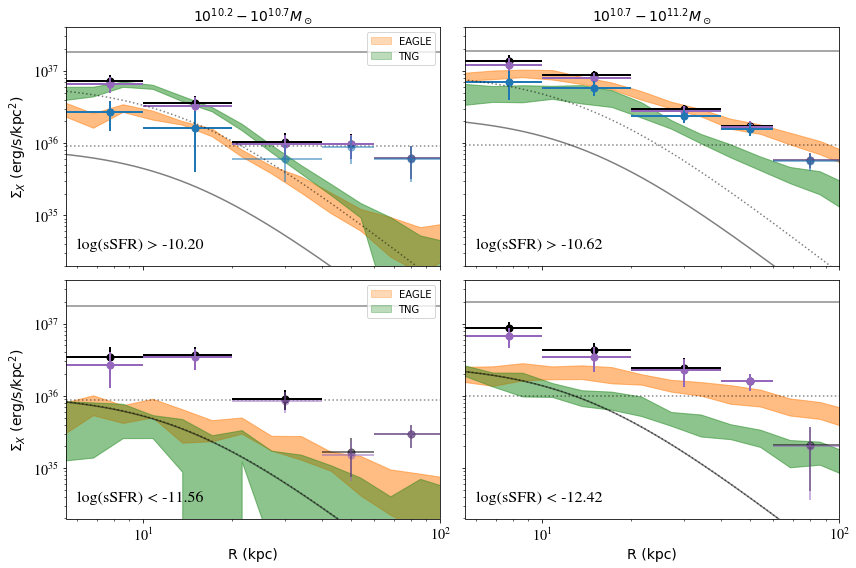

In [191]:
sb_err_high_sf_raw = sb_prof(src[high].iloc[highsf], mincts=-10, bck='all', model='Lehmer10')
sb_err_high_q_raw = sb_prof(src[high].iloc[highq], mincts=-10, bck='all', model='Lehmer10')
sb_err_low_sf_raw = sb_prof(src[low].iloc[lowsf], mincts=-10, bck='all', model='Lehmer10')
sb_err_low_q_raw = sb_prof(src[low].iloc[lowq], mincts=-10, bck='all', model='Lehmer10')

sb_err_high_sf_lxrb = sb_prof(src[high].iloc[highsf], xrb=True, nobeta=True, mincts=-10, bck='all', model='Lehmer10')
sb_err_high_q_lxrb = sb_prof(src[high].iloc[highq], xrb=True, nobeta=True, mincts=-10, bck='all', model='Lehmer10')
sb_err_low_sf_lxrb = sb_prof(src[low].iloc[lowsf], xrb=True, nobeta=True, mincts=-10,bck='all', model='Lehmer10')
sb_err_low_q_lxrb = sb_prof(src[low].iloc[lowq], xrb=True, nobeta=True, mincts=-10, bck='all', model='Lehmer10')

print('HXMB')
sb_err_high_sf_xrb = sb_prof(src[high].iloc[highsf], xrb=True, mincts=-10, bck='all', model='Lehmer10')
sb_err_high_q_xrb = sb_prof(src[high].iloc[highq], xrb=True, mincts=-10,  bck='all', model='Lehmer10')
sb_err_low_sf_xrb = sb_prof(src[low].iloc[lowsf], xrb=True, mincts=-10, bck='all', model='Lehmer10')
sb_err_low_q_xrb = sb_prof(src[low].iloc[lowq], xrb=True, mincts=-10, bck='all', model='Lehmer10')

#Good! The XRB flux in the bins adds up to just less than the total, which includes r --> inf, so perfectly consistent.
fig, ax = plt.subplots(ncols=2,nrows=2,sharex=True, sharey=True, figsize=(12,8))
ax1, ax2,ax3,ax4 = ax.flatten()
plot_sim_profiles(lsb_sf, src[low].iloc[lowsf], ax1, simsfile='../BenData/SBprof_disp.EAGLE_TNG.Ms10.20_10.70Mila.sSFR.docalc.20.list.SB_stats.out',q=False, xrb=True,ls='dotted', label=True,model='Lehmer10')
plot_sim_profiles(hsb_sf, src[high].iloc[highsf], ax2, simsfile='../BenData/SBprof_disp.EAGLE_TNG.Ms10.70_11.20Mila.sSFR.docalc.20.list.SB_stats.out', y=False,q=False, xrb=True,ls='dotted',model='Lehmer10')

plot_sim_profiles(lsb_q, src[low].iloc[lowq], ax3, simsfile='../BenData/SBprof_disp.EAGLE_TNG.Ms10.20_10.70Mila.sSFR.docalc.20.list.SB_stats.out',sf=False, xrb=True, ls='dotted', label=True,model='Lehmer10')
plot_sim_profiles(hsb_q, src[high].iloc[highq], ax4, simsfile='../BenData/SBprof_disp.EAGLE_TNG.Ms10.70_11.20Mila.sSFR.docalc.20.list.SB_stats.out', y=False,sf=False, xrb=True, ls='dotted',model='Lehmer10')

plot_sim_profiles(lsb_sf, src[low].iloc[lowsf], ax1, simsfile='../BenData/SBprof_disp.EAGLE_TNG.Ms10.20_10.70Mila.sSFR.docalc.20.list.SB_stats.out',q=False, xrb=True, nobeta=True,model='Lehmer10')
plot_sim_profiles(hsb_sf, src[high].iloc[highsf], ax2, simsfile='../BenData/SBprof_disp.EAGLE_TNG.Ms10.70_11.20Mila.sSFR.docalc.20.list.SB_stats.out', y=False,q=False, xrb=True, nobeta=True,model='Lehmer10')

plot_sim_profiles(lsb_q, src[low].iloc[lowq], ax3, simsfile='../BenData/SBprof_disp.EAGLE_TNG.Ms10.20_10.70Mila.sSFR.docalc.20.list.SB_stats.out',sf=False, xrb=True, nobeta=True,model='Lehmer10')
plot_sim_profiles(hsb_q, src[high].iloc[highq], ax4, simsfile='../BenData/SBprof_disp.EAGLE_TNG.Ms10.70_11.20Mila.sSFR.docalc.20.list.SB_stats.out', y=False,sf=False, xrb=True, nobeta=True,model='Lehmer10')

plt.ylim(2e34,4e37)
ax1.set_xlabel(''); ax2.set_xlabel(''); plt.tight_layout()
print(sb_err_high_q_xrb)
ax[0][0].set_title(r'$10^{10.2} - 10^{10.7} M_\odot$', fontsize=14)
ax[0][1].set_title(r'$10^{10.7} - 10^{11.2} M_\odot$', fontsize=14)
ax[0][0].text(6, 3.5e34, 'log(sSFR) > -10.20', fontsize=16, fontfamily='STIXGeneral')
ax[0][1].text(6, 3.5e34, 'log(sSFR) > -10.62', fontsize=16, fontfamily='STIXGeneral')
ax[1][0].text(6, 3.5e34, 'log(sSFR) < -11.56', fontsize=16, fontfamily='STIXGeneral')
ax[1][1].text(6, 3.5e34, 'log(sSFR) < -12.42', fontsize=16, fontfamily='STIXGeneral')

plot(sb_err_low_sf_raw, ax1, 'k', nsigma=2,  bkg=0.05*lsb_sf)
plot(sb_err_high_sf_raw, ax2, 'k', nsigma=2,  bkg=0.05*hsb_sf)
plot(sb_err_low_q_raw, ax3, 'k', nsigma=2,  bkg=0.05*lsb_q)
plot(sb_err_high_q_raw, ax4, 'k', nsigma=2,  bkg=0.05*hsb_q)
plt.tight_layout()
plt.savefig('../profiles-logr.png')
plot(sb_err_low_sf_lxrb, ax1, 'tab:purple', nsigma=2,  bkg=0.05*lsb_sf)
plot(sb_err_high_sf_lxrb, ax2, 'tab:purple', nsigma=2,  bkg=0.05*hsb_sf)
plot(sb_err_low_q_lxrb, ax3, 'tab:purple', nsigma=2,  bkg=0.05*lsb_q)
plot(sb_err_high_q_lxrb, ax4, 'tab:purple', nsigma=2,  bkg=0.05*hsb_q)
plt.savefig('../profiles-logr-noLxrb.png')
plot(sb_err_low_sf_xrb, ax1, 'tab:blue', nsigma=2, bkg=0.05*lsb_sf)
plot(sb_err_high_sf_xrb, ax2, 'tab:blue', nsigma=2, bkg=0.05*lsb_q)
# plot(sb_err_low_q_xrb, ax3, cm.tab20c(8), nsigma=2, bkg=0.05*hsb_sf)
# plot(sb_err_high_q_xrb, ax4, cm.tab20c(8), nsigma=2, bkg=0.05*hsb_q)

# plot(sb_err_high_q_xrb, ax4, cm.tab20c(0), nsigma=0, bkg=0.05*hsb_q, marker='^')


plt.savefig('../profiles-logr-sfr.png',dpi=156)

In [527]:
sb_err_high_sf_raw = sb_prof(src[high].iloc[highsf], mincts=-10, bck='all', model='Lehmer16')
sb_err_high_q_raw = sb_prof(src[high].iloc[highq], mincts=-10, bck='all', model='Lehmer16')
sb_err_low_sf_raw = sb_prof(src[low].iloc[lowsf], mincts=-10, bck='all', model='Lehmer16')
sb_err_low_q_raw = sb_prof(src[low].iloc[lowq], mincts=-10, bck='all', model='Lehmer16')

sb_err_high_sf_lxrb = sb_prof(src[high].iloc[highsf], xrb=True, nobeta=True, mincts=-10, bck='all', model='Lehmer16')
sb_err_high_q_lxrb = sb_prof(src[high].iloc[highq], xrb=True, nobeta=True, mincts=-10, bck='all', model='Lehmer16')
sb_err_low_sf_lxrb = sb_prof(src[low].iloc[lowsf], xrb=True, nobeta=True, mincts=-10,bck='all', model='Lehmer16')
sb_err_low_q_lxrb = sb_prof(src[low].iloc[lowq], xrb=True, nobeta=True, mincts=-10, bck='all', model='Lehmer16')

print('HXMB')
sb_err_high_sf_xrb = sb_prof(src[high].iloc[highsf], xrb=True, mincts=-10, bck='all', model='Lehmer16')
sb_err_high_q_xrb = sb_prof(src[high].iloc[highq], xrb=True, mincts=-10,  bck='all', model='Lehmer16')
sb_err_low_sf_xrb = sb_prof(src[low].iloc[lowsf], xrb=True, mincts=-10, bck='all', model='Lehmer16')
sb_err_low_q_xrb = sb_prof(src[low].iloc[lowq], xrb=True, mincts=-10, bck='all', model='Lehmer16')

#Good! The XRB flux in the bins adds up to just less than the total, which includes r --> inf, so perfectly consistent.
fig, ax = plt.subplots(ncols=2,nrows=2,sharex=True, sharey=True, figsize=(12,8))
ax1, ax2,ax3,ax4 = ax.flatten()
plot_sim_profiles(lsb_sf, src[low].iloc[lowsf], ax1, simsfile='../BenData/SBprof_disp.EAGLE_TNG.Ms10.20_10.70Mila.sSFR.docalc.20.list.SB_stats.out',q=False, xrb=True,ls='dotted', label=True,model='Lehmer16')
plot_sim_profiles(hsb_sf, src[high].iloc[highsf], ax2, simsfile='../BenData/SBprof_disp.EAGLE_TNG.Ms10.70_11.20Mila.sSFR.docalc.20.list.SB_stats.out', y=False,q=False, xrb=True,ls='dotted',model='Lehmer16')

plot_sim_profiles(lsb_q, src[low].iloc[lowq], ax3, simsfile='../BenData/SBprof_disp.EAGLE_TNG.Ms10.20_10.70Mila.sSFR.docalc.20.list.SB_stats.out',sf=False, xrb=True, ls='dotted', label=True,model='Lehmer16')
plot_sim_profiles(hsb_q, src[high].iloc[highq], ax4, simsfile='../BenData/SBprof_disp.EAGLE_TNG.Ms10.70_11.20Mila.sSFR.docalc.20.list.SB_stats.out', y=False,sf=False, xrb=True, ls='dotted',model='Lehmer16')

plot_sim_profiles(lsb_sf, src[low].iloc[lowsf], ax1, simsfile='../BenData/SBprof_disp.EAGLE_TNG.Ms10.20_10.70Mila.sSFR.docalc.20.list.SB_stats.out',q=False, xrb=True, nobeta=True,model='Lehmer16')
plot_sim_profiles(hsb_sf, src[high].iloc[highsf], ax2, simsfile='../BenData/SBprof_disp.EAGLE_TNG.Ms10.70_11.20Mila.sSFR.docalc.20.list.SB_stats.out', y=False,q=False, xrb=True, nobeta=True,model='Lehmer16')

plot_sim_profiles(lsb_q, src[low].iloc[lowq], ax3, simsfile='../BenData/SBprof_disp.EAGLE_TNG.Ms10.20_10.70Mila.sSFR.docalc.20.list.SB_stats.out',sf=False, xrb=True, nobeta=True,model='Lehmer16')
plot_sim_profiles(hsb_q, src[high].iloc[highq], ax4, simsfile='../BenData/SBprof_disp.EAGLE_TNG.Ms10.70_11.20Mila.sSFR.docalc.20.list.SB_stats.out', y=False,sf=False, xrb=True, nobeta=True,model='Lehmer16')

plt.ylim(2e34,4e37)
ax1.set_xlabel(''); ax2.set_xlabel(''); plt.tight_layout()
print(sb_err_high_q_xrb)
ax[0][0].set_title(r'$10^{10.2} - 10^{10.7} M_\odot$', fontsize=14)
ax[0][1].set_title(r'$10^{10.7} - 10^{11.2} M_\odot$', fontsize=14)
ax[0][0].text(6, 3.5e34, 'log(sSFR) > -10.20', fontsize=16, fontfamily='STIXGeneral')
ax[0][1].text(6, 3.5e34, 'log(sSFR) > -10.62', fontsize=16, fontfamily='STIXGeneral')
ax[1][0].text(6, 3.5e34, 'log(sSFR) < -11.56', fontsize=16, fontfamily='STIXGeneral')
ax[1][1].text(6, 3.5e34, 'log(sSFR) < -12.42', fontsize=16, fontfamily='STIXGeneral')

plot(sb_err_low_sf_raw, ax1, 'k', nsigma=2,  bkg=0.05*lsb_sf)
plot(sb_err_high_sf_raw, ax2, 'k', nsigma=2,  bkg=0.05*hsb_sf)
plot(sb_err_low_q_raw, ax3, 'k', nsigma=2,  bkg=0.05*lsb_q)
plot(sb_err_high_q_raw, ax4, 'k', nsigma=2,  bkg=0.05*hsb_q)
plt.tight_layout()
plt.savefig('../profiles-logr.png')
plot(sb_err_low_sf_lxrb, ax1, 'tab:purple', nsigma=2,  bkg=0.05*lsb_sf)
plot(sb_err_high_sf_lxrb, ax2, 'tab:purple', nsigma=2,  bkg=0.05*hsb_sf)
plot(sb_err_low_q_lxrb, ax3, 'tab:purple', nsigma=2,  bkg=0.05*lsb_q)
plot(sb_err_high_q_lxrb, ax4, 'tab:purple', nsigma=2,  bkg=0.05*hsb_q)
plt.savefig('../profiles-logr-noLxrb.png')
plot(sb_err_low_sf_xrb, ax1, 'tab:blue', nsigma=2, bkg=0.05*lsb_sf)
plot(sb_err_high_sf_xrb, ax2, 'tab:blue', nsigma=2, bkg=0.05*lsb_q)
# plot(sb_err_low_q_xrb, ax3, cm.tab20c(8), nsigma=2, bkg=0.05*hsb_sf)
# plot(sb_err_high_q_xrb, ax4, cm.tab20c(8), nsigma=2, bkg=0.05*hsb_q)

# plot(sb_err_high_q_xrb, ax4, cm.tab20c(0), nsigma=0, bkg=0.05*hsb_q, marker='^')


plt.savefig('../profiles-logr-sfr.png',dpi=156)

ValueError: Boolean array expected for the condition, not object

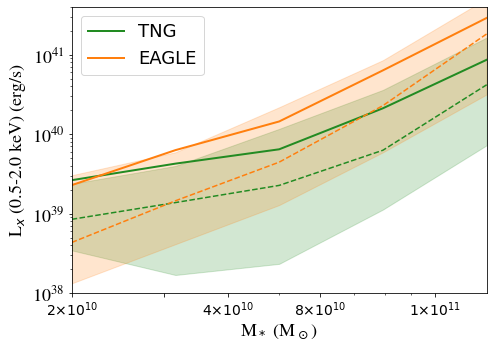

In [51]:
fig, ax = plt.subplots(figsize=(7,5))

# ax.scatter(10**mtng, Lx_tng, color='coral', alpha=0.075)
# ax.scatter(10**meag, Lx_eag, color='darkgreen', alpha=0.075)

mean_tng = []
mean_eag = []
median_tng = []
median_eag = []
low_tng = []
low_eag = []
high_tng = []
high_eag = []

Mleft = np.linspace(10.2, 11.0, 5)
Mright = Mleft + 0.2

for i in range(len(Mright)):
    tng = Lx_tng[(mtng > Mleft[i])*(mtng < Mright[i])]
    eag = Lx_eag[(meag > Mleft[i])*(meag < Mright[i])]
    
    ssfrtng = tng0510[(mtng > Mleft[i])*(mtng < Mright[i])][:,5]
    ssfreag = eagle0510[(meag > Mleft[i])*(meag < Mright[i])][:,5]

    redtng = np.argsort(ssfrtng)[:int(len(tng)/3.)]
    bluetng = np.argsort(ssfrtng)[int(2*len(tng)/3.):]
    redeag = np.argsort(ssfreag)[:int(len(eag)/3.)]
    blueeag = np.argsort(ssfreag)[int(2*len(eag)/3.):]

    mean_tng.append(np.nanmean(tng))
    low_tng.append(np.nanpercentile(tng, 16))
    high_tng.append(np.nanpercentile(tng, 84))
    median_tng.append(np.nanmedian(tng))
    mean_eag.append(np.nanmean(eag))
    low_eag.append(np.nanpercentile(eag, 16))
    high_eag.append(np.nanpercentile(eag, 84))
    median_eag.append(np.nanmedian(eag))

mean_tng = np.array(mean_tng)
mean_eag = np.array(mean_eag)
low_tng = np.array(low_tng)
low_eag = np.array(low_eag)
high_tng = np.array(high_tng)
high_eag = np.array(high_eag)

ax.plot(10**((Mleft+Mright)/2), mean_tng, color='forestgreen', label='TNG', linewidth=2)
ax.plot(10**((Mleft+Mright)/2), mean_eag, color='tab:orange', label='EAGLE', linewidth=2)
ax.fill_between(10**((Mleft+Mright)/2), low_tng, high_tng, color='forestgreen', alpha=0.2)
ax.fill_between(10**((Mleft+Mright)/2), low_eag, high_eag, color='tab:orange', alpha=0.2)
ax.plot(10**((Mleft+Mright)/2), np.array(median_tng), color='forestgreen', linestyle='dashed')
ax.plot(10**((Mleft+Mright)/2), np.array(median_eag), color='tab:orange', linestyle='dashed')
ax.legend(fontsize=18)
    
ax.set_yticks([1e38,1e40,1e42])
ax.set_yticklabels([r'10$^{38}$',r'10$^{40}$',r'10$^{42}$'],fontsize=18, fontfamily='STIXGeneral')
# ax.set_xticklabels(['',r'10$^{10}$',r'10$^{11}$','',''],fontsize=18, fontfamily='STIXGeneral')
ax.set_xlabel(r'M$_*$ (M$_\odot$)', fontfamily='STIXGeneral', fontsize=18)
ax.set_ylabel(r'L$_x$ (0.5-2.0 keV) (erg/s)', fontfamily='STIXGeneral', fontsize=18)
ax.figure.tight_layout()
ax.set_xscale('log'); ax.set_yscale('log')
ax.set_xticks([2e10,3e10,4e10,6e10,1e11])
ax.set_xticklabels([r'2$\times10^{10}$','',r'4$\times10^{10}$',r'8$\times10^{10}$',r'1$\times10^{11}$'], fontsize=14)
ax.set_xlabel(r'M$_*$ (M$_\odot$)', fontfamily='STIXGeneral', fontsize=18)
ax.set_ylim(1e38,4e41)
ax.set_xlim(10**10.3,10**11.1)
plt.savefig('../Lx-Mstar-sim.png', dpi=156)

The Eagle stacks evolve the most rapidly, followed by TNG and then observations. This could be because the Eagle stellar mass distribution is much steeper than that for TNG, which in turn agrees with SDSS. As a result, within the low-mass stack, Eagle is dominated by lower-mass galaxies, at the central mass bin they all agree, and at the highest mass it has only a handful of galaxies. 

## Sample Bias

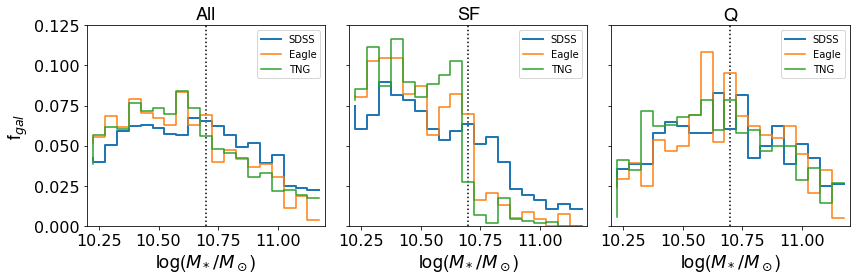

In [84]:
meag = np.concatenate((eag_low[:,2], eag_high[:,2]))
mtng = np.concatenate((tng_low[:,2], tng_high[:,2]))
mobs = sdss['logMass']
fig, ax = plt.subplots(ncols = 3, sharex=True, sharey=True, figsize=(12,4))
ax1, ax2, ax3 = ax.flatten()
eag = np.concatenate((eag_low[:,3], eag_high[:,3]))
tng = np.concatenate((tng_low[:,3], tng_high[:,3]))
eag_q = np.argsort(eag)[:int(len(eag)/3.)]
eag_sf = np.argsort(eag)[int(2*len(eag)/3.):]
tng_q = np.argsort(tng)[:int(len(tng)/3.)]
tng_sf = np.argsort(tng)[int(2*len(tng)/3.):]
q = np.argsort(sdss['ssfr'])[:int(len(mobs)/3.)]
sf = np.argsort(sdss['ssfr'])[int(2*len(mobs)/3.):]

def mhist(meag, mtng, mobs, ax=None, nbins=20):
    histeag, bins = np.histogram(meag, bins=nbins, range=(10.2, 11.2), density=True)
    histtng, bins = np.histogram(mtng, bins=nbins, range=(10.2, 11.2), density=True)
    histobs, bins = np.histogram(mobs, bins=nbins, range=(10.2, 11.2), density=True)
    if ax:
        ax.step((bins[1:]+bins[:-1])/2., histobs/sum(histobs), label='SDSS',  linewidth=2)
        ax.step((bins[1:]+bins[:-1])/2., histeag/sum(histeag), label='Eagle')
        ax.step((bins[1:]+bins[:-1])/2., histtng/sum(histtng), label='TNG')
        ax.legend()
        ax.set_xlim(10.2, 11.2)
        ax.set_xlabel(r'log($M_*/M_\odot$)', fontsize=16, font=font)
    else:
        return bins, histtng/histobs, histeag/histobs
    
mhist(meag, mtng, mobs, ax1)
mhist(meag[eag_sf], mtng[tng_sf], mobs[sf], ax2)
mhist(meag[eag_q], mtng[tng_q], mobs[q], ax3)
ax1.set_ylabel(r'f$_{gal}$', fontsize=14, font=font)
ax1.set_title('All', fontsize=16, font=font)
ax2.set_title('SF', fontsize=16, font=font)
ax3.set_title('Q', fontsize=16, font=font)
for a in ax.flatten():
    a.vlines(10.7, 0, .16, color='k', linestyle='dotted')
ax1.set_ylim(0,.125)
plt.tight_layout()
plt.savefig('../mstar-hist.png')

Text(0.5, 1.0, 'log(M*/Msun) 10.7-11.2')

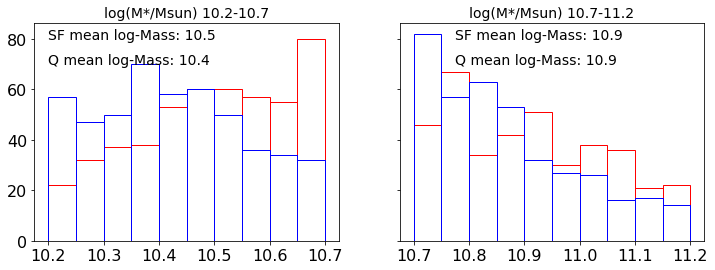

In [127]:
low = sdss[sdss['logMass'] < 10.7]
high = sdss[sdss['logMass'] > 10.7]
lowq = np.argsort(low['ssfr'])[:int(len(low)/3.)]
lowsf = np.argsort(low['ssfr'])[int(2*len(low)/3.):]
highq = np.argsort(high['ssfr'])[:int(len(high)/3.)]
highsf = np.argsort(high['ssfr'])[int(2*len(high)/3.):]
fig, ax = plt.subplots(ncols=2, sharey=True, figsize=(12,4))
ax[0].text(10.2,80, 'SF mean log-Mass: %0.1f' % np.mean(low[lowq]['logMass']), fontsize=14)
ax[0].text(10.2,70, 'Q mean log-Mass: %0.1f' % np.mean(low[lowsf]['logMass']), fontsize=14)
ax[1].text(10.775,80, 'SF mean log-Mass: %0.1f' % np.mean(high[highq]['logMass']), fontsize=14)
ax[1].text(10.775,70, 'Q mean log-Mass: %0.1f' % np.mean(high[highsf]['logMass']), fontsize=14)
ax[0].hist(low[lowq]['logMass'], range=(10.2, 10.7), bins=10, edgecolor='r', fill=False)
ax[0].hist(low[lowsf]['logMass'], range=(10.2, 10.7), bins=10, edgecolor='b', fill=False)
# ax[1].hist(high['logMass'], range=(10.7, 11.2), bins=10, edgecolor='k', fill=False)
ax[1].hist(high[highq]['logMass'], range=(10.7, 11.2), bins=10, edgecolor='r', fill=False)
ax[1].hist(high[highsf]['logMass'], range=(10.7, 11.2), bins=10, edgecolor='b', fill=False)
ax[0].set_title('log(M*/Msun) 10.2-10.7',fontsize=14)
ax[1].set_title('log(M*/Msun) 10.7-11.2',fontsize=14)

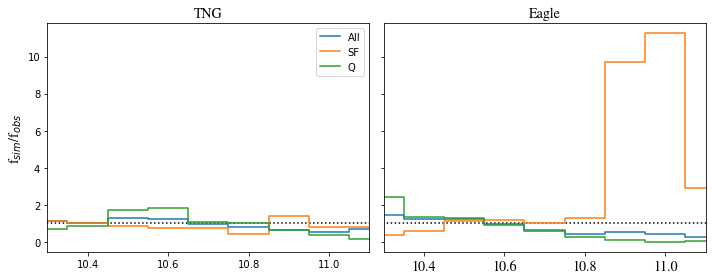

In [745]:
bins, ftng, feag = mhist(meag, mtng, mobs, nbins=10)
bins, ftng_sf, feag_sf = mhist(meag[eag_sf], mtng[tng_sf], mobs[sf], nbins=10)
bins, ftng_q, feag_q = mhist(meag[eag_q], mtng[tng_q], mobs[q], nbins=10)
fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(10,4))
ax[0].step((bins[1:]+bins[:-1])/2., ftng, label='All')
ax[0].step((bins[1:]+bins[:-1])/2., ftng_sf, label='SF')
ax[0].step((bins[1:]+bins[:-1])/2., ftng_q, label='Q')

ax[1].step((bins[1:]+bins[:-1])/2., feag, label='All')
ax[1].step((bins[1:]+bins[:-1])/2., feag_sf, label='SF')
ax[1].step((bins[1:]+bins[:-1])/2., feag_q, label='Q')

ax[0].legend()
ax[0].set_title('TNG', fontsize=14, fontfamily='STIXGeneral')
ax[1].set_title('Eagle', fontsize=14, fontfamily='STIXGeneral')
ax[0].set_ylabel(r'f$_{sim}$/f$_{obs}$', fontsize=14, fontfamily='STIXGeneral')
ax[0].hlines(1, 10.2, 11.2, color='k', linestyle='dotted')
ax[1].hlines(1, 10.2, 11.2, color='k', linestyle='dotted')
plt.xlim(10.3,11.1)
plt.xticks([10.4,10.6,10.8,11.0], fontsize=14, fontfamily='STIXGeneral')
# plt.yticks([2,4,6,8], fontsize=14, fontfamily='STIXGeneral')
plt.tight_layout()

For every galaxy simulated, we actually observe this many ^ galaxies. I.e. the simulated galaxy needs to be multiplied by this much before adding. The dashed line shows 1, i.e. a no correction needed.

In [749]:
conversions = np.zeros((10,7))
conversions[:,0] = (bins[1:] + bins[:-1])/2.
conversions[:,1] = ftng
conversions[:,2] = ftng_sf
conversions[:,3] = ftng_q
conversions[:,4] = feag
conversions[:,5] = feag_sf
conversions[:,6] = feag_q
np.savetxt('conversions.csv', conversions, delimiter=',')

In [1163]:
def construct_table(cts, exp, area, radec):
    src = pd.DataFrame()
    src.insert(0, 'ra', radec[:,0])
    src.insert(1, 'dec', radec[:,1])
    src.insert(2, 'z', sdss.iloc[inds]['z'].values)
    src.insert(3, 'logMass', sdss.iloc[inds]['logMass'].values)
    src.insert(4, 'ssfr', sdss.iloc[inds]['ssfr'].values)
    src.insert(5, 'cts-0-5.5', cts[:, 0])
    src.insert(6, 'cts-5.5-10', cts[:, 1])
    src.insert(7, 'cts-10-20', cts[:, 2])
    src.insert(8, 'cts-20-40', cts[:, 3])
    src.insert(9, 'cts-40-60', cts[:, 4])
    src.insert(10, 'cts-60-100', cts[:, 5])
    src.insert(11, 'bck-cts', cts[:, 6])
    src.insert(12, 'exp-0-5.5', exp[:,0])
    src.insert(13, 'exp-5.5-10', exp[:,1])
    src.insert(14, 'exp-10-20', exp[:,2])
    src.insert(15, 'exp-20-40', exp[:,3])
    src.insert(16, 'exp-40-60', exp[:,4])
    src.insert(17, 'exp-60-100', exp[:,5])
    src.insert(18, 'bck-exp', exp[:,6])
    src.insert(19, 'area-0-5.5', area[:,0])
    src.insert(20, 'area-5.5-10', area[:,1])
    src.insert(21, 'area-10-20', area[:,2])
    src.insert(22, 'area-20-40', area[:,3])
    src.insert(23, 'area-40-60', area[:,4])
    src.insert(24, 'area-60-100', area[:,5])
    src.insert(25, 'bck-area', area[:,6])
    return src

(7.888016571050706e+28, 3.605519214113673e+39)

I think what we're learning here is that the XRB model is fairly conservative. If it completely removes central emission but leaves emission in the outskirts (high mass, quenched; low-mass SF), those outer detections are very robust. Conversely, if it retains central emission but is dim in the outskirts (low mass, quenched), the outskirts are definitely undetected. 

I do think there is a 

In [1150]:
psf = {}
for (e, r) in zip(eef,cdf):
    psf[e] = r

In [1151]:
psf

{0.4: 2.3682704,
 0.45: 2.676496,
 0.5: 3.0556135,
 0.55: 3.492052,
 0.6: 4.041087,
 0.6499999999999999: 4.647543,
 0.7: 5.309737,
 0.75: 6.1029196,
 0.7999999999999999: 7.200887,
 0.8499999999999999: 8.627701,
 0.8999999999999999: 10.747527,
 0.9499999999999998: 15.137898}

3.2


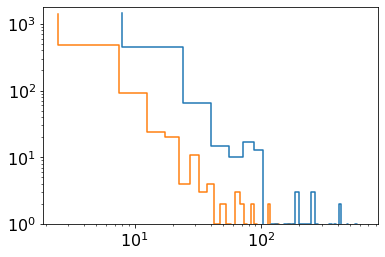

In [883]:
#The SB excess at 40-100 kpc in low-M* SF stack - is it real?
#Let's find and exclude the brighest galaxies
ratio = (100**2 - 60**2)/(60**2 - 40**2)
cmin = 0; cmax=200
print(ratio)
h1, b1 = np.histogram(prof0520['cts-40-60'], bins=int((cmax-cmin)/5), range=(cmin,cmax))
h2, b2 = np.histogram(prof0520['cts-60-100'], bins=int((cmax-cmin)/5), range=(cmin*ratio,cmax*ratio))

plt.step((b1[:-1]+b1[1:])/2., h1, color='tab:orange')
plt.step((b2[:-1]+b2[1:])/2., h2, color='tab:blue')
plt.yscale('log')
plt.ylim(1,1800)
plt.xscale('log')

In [889]:
# weird = np.argwhere(prof0520['cts-40-60'].values>200).flatten()
# weird2 = np.argwhere(prof0520['cts-60-100'].values>200).flatten()
# len(weird2), prof0520.iloc[weird2]['logMass'], prof0520.iloc[weird2]['ssfr']#, prof0520.iloc[weird]
top, bottom = sort(prof0520[prof0520['logMass'] < 10.7])
sf = prof0520[prof0520['logMass'] < 10.7].iloc[top]
q = prof0520[prof0520['logMass'] < 10.7].iloc[bottom]
weird = np.argwhere(q['cts-60-100'].values>20).flatten()
weird2 = np.argwhere(sf['cts-60-100'].values>20).flatten()
# print(sf.iloc[weird2]['ra'],sf.iloc[weird2]['dec'])#, sf.iloc[weird]['ra'], sf.iloc[weird]['dec'])
hotgals = np.zeros((len(weird2)+len(weird),2))
hotgals[:,0] = np.concatenate((sf.iloc[weird2]['ra'], q.iloc[weird]['ra']))
hotgals[:,1] = np.concatenate((sf.iloc[weird2]['dec'], q.iloc[weird]['dec']))
inds = crossmatch(hotgals, prof0520, arr=True)
print((inds,prof0520.iloc[inds].index))
# print(sf['ssfr'].min(), len(top), len(bottom))
cut = prof0520
for ind in prof0520.iloc[inds].index:
    cut = cut.drop(ind,axis=0)

print(len(inds), len(sf))
#why is this affecting the QUENCHED stack??

([886, 1103, 1234, 1422, 1611, 1911, 1049, 1392, 1930, 497, 287, 984, 793, 618, 994, 1588, 949, 1466, 1619, 1932, 1217, 154, 933, 1802, 1490, 1962, 256, 79, 13, 370, 1294, 834, 1055, 334, 1375, 1363, 1186, 768, 29, 697, 1974, 1828, 1770, 909, 455, 1564, 327, 417, 130, 1948, 1057, 1971, 1209, 884, 322, 1616, 664, 876, 1800, 616, 1993, 942, 1677, 1380, 1817, 638, 1696, 183, 1706, 1161, 1382, 525, 990, 811, 134, 1968, 496, 1519, 777, 1078, 1875, 131, 1558, 1573, 27, 240, 1446, 1733, 767, 1498, 808, 1963, 989, 132, 414, 1306, 359, 472, 1746, 1062, 297, 815, 816, 1420, 1473, 2027, 527, 1431, 1485, 32, 857, 671, 388, 479, 1615, 544, 1692, 1002, 200, 259, 169], Int64Index([1418, 1777, 1994, 2303, 2604, 3054, 1686, 2254, 3086,  770,
            ...
            1064,  600,  739, 2608,  845, 2723, 1612,  308,  396,  257],
           dtype='int64', length=121))
121 384


# Hardness Ratios

In [937]:
def cts_area_ratio(tab, prof=False, bck='bck-area'):
	if prof:
		cts = (tab['cts-0-5.5']+tab['cts-5.5-10']).sum()
		if bck == 'bck-area':
			bck_cts = tab['bck-cts'].sum()
			area = tab['bck-area']/(tab['area-0-5.5']+tab['area-5.5-10'])
		else:
			bck_cts = tab['150-250-cts'].sum()
			area = tab['150-250-area']/(tab['area-0-5.5']+tab['area-5.5-10'])
	else:
		cts = tab['cts'].sum()
		if bck == 'bck-area':
			bck_cts = tab['bck-cts'].sum()
			area = tab['bck-area']/(tab['area'])
		else:
			bck_cts = tab['150-250-cts'].sum()
			area = tab['150-250-area']/(tab['area'])
	return cts, bck_cts, np.nanmean(area[area<np.inf])

def hardness_ratio(hard,soft, prof=False):
	softsrc, softbck, softarea = cts_area_ratio(soft, prof=prof)
	allsrc, allbck, allarea = cts_area_ratio(hard, prof=prof) 
	print(int(softsrc), int(softbck), softarea, int(allsrc-softsrc), int(allbck-softbck), allarea)
	return int(softsrc), int(softbck), softarea, int(allsrc-softsrc), int(allbck-softbck), allarea

# print('low mass, 0-10: ');hardness_ratio(prof0520[prof0520['logMass'] < 10.7], prof0510[prof0520['logMass'] < 10.7], prof=True)
# print('high mass, 0-10: ');hardness_ratio(prof0520[prof0520['logMass'] > 10.7], prof0510[prof0520['logMass'] > 10.7], prof=True)

low mass, 10-100: 
20802 23019 1.2142878669646995 9120 10326 1.2142878669646995
high mass, 10-100: 
16203 17380 1.1538900382047819 7370 7661 1.1538900382047819


(16203, 17380, 1.1538900382047819, 7370, 7661, 1.1538900382047819)

In [877]:
src0520 = pd.read_csv('../src_bck_cts.csv')
src0510 = pd.read_csv('../src_bck_cts_0510.csv')
print('low mass, 10-100: '); hardness_ratio(src0520[src0520['logMass'] < 10.7], src0510[src0510['logMass'] < 10.7], prof=False)
print('high mass, 10-100: ');hardness_ratio(src0520[src0520['logMass'] > 10.7], src0510[src0510['logMass'] > 10.7], prof=False)

low0520 = prof0520[prof0520['logMass'] < 10.7]
lowsf, lowq = sort(low0520)
low0510 = prof0510[prof0510['logMass'] < 10.7]
lowsfsoft, lowqsoft = sort(low0510)
high0520 = prof0520[prof0520['logMass'] > 10.7]
highsf, highq = sort(high0520)
high0510 = prof0510[prof0510['logMass'] > 10.7]
highsfsoft, highqsoft = sort(high0510)
low0510['cts-0-5.5'].sum()+low0510['cts-5.5-10'].sum()
low0510['cts-0-5.5'].sum()+low0510['cts-5.5-10'].sum()

478.45403481274843

In [169]:
eef, cdf

(array([0.4 , 0.45, 0.5 , 0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 ,
        0.95]),
 array([ 2.3682704,  2.676496 ,  3.0556135,  3.492052 ,  4.041087 ,
         4.647543 ,  5.309737 ,  6.1029196,  7.200887 ,  8.627701 ,
        10.747527 , 15.137898 ], dtype=float32))

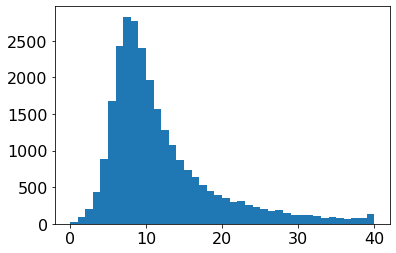

In [178]:
cts = ptsrc['APE_CTS_s']; bkg = ptsrc['APE_BKG_s']
snr = (cts - bkg)/np.sqrt(cts+bkg)
_ = plt.hist(cts, bins=40, range=(0,40))

(0.0, 0.3)

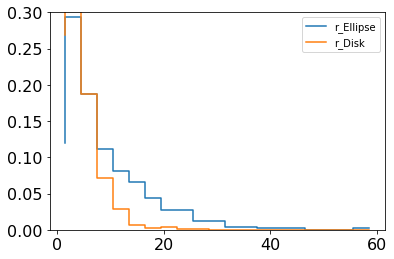

In [532]:
radii = pd.read_csv('../sdss_radii.csv',header=1)
hist_d, bins = np.histogram(2*radii['deVRad_i'], bins=20, range=(0,60))
hist_e, bins = np.histogram(2*radii['expRad_i'], bins=20, range=(0,60))
plt.step((bins[:-1]+bins[1:])/2., hist_d/len(radii), label='r_Ellipse')
plt.step((bins[:-1]+bins[1:])/2., hist_e/len(radii), label='r_Disk')
plt.legend()
plt.ylim(0,.3)
# len(radii)
# np.median(radii['deVRad_i']),np.mean(radii['deVRad_i']),np.median(radii['deVRad_u']),np.mean(radii['deVRad_u'])  

25 84


Text(0, 0.5, 'N')

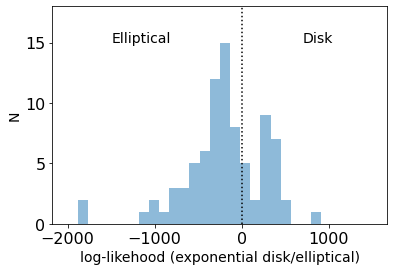

In [533]:
good = radii[(radii['lnLExp_i'] > -10) + (radii['lnLDeV_i'] > -10)]
_ = plt.hist(good['lnLExp_i']- good['lnLDeV_i'], range=(-2000,1500), bins=30, alpha=0.5)
print(len(good[good['lnLExp_i'] > good['lnLDeV_i']]), len(good)) #ok so ~1/2 the galaxies are better fit by exponentials
plt.vlines(0, 0, 18, color='k', linestyle='dotted')
plt.text(-1500, 15, 'Elliptical', fontsize=14)
plt.text(700, 15, 'Disk', fontsize=14)
plt.ylim(0,18)
plt.xlabel('log-likehood (exponential disk/elliptical)', fontsize=14)
plt.ylabel('N', fontsize=14)
# len() #but only 84 galaxies are well fit by either!!

In [514]:
# from astropy.modeling.core import Fittable1DModel
# Fittable1DModel(amplitude=amplitude_at_reff, r_eff=radii['deVRad_i'].mean(), n=4, name='Sersic1D')
# Fittable1DModel(amplitude, tau, name='Exponential1D')

# or https://www.sdss.org/dr17/algorithms/magnitudes/
from scipy.signal import convolve

def deVaucoleurs(r, r_eff):
    #between re/50 and 7re
    return np.array([np.exp(-7.67*((r/r_effi)**.25)) for r_effi in r_eff])

def exponential(r, r_s):
    #upto 3re
    return np.array([np.exp(-1.68*r/r_si) for r_si in r_s]) 

def xrb_psf_gal(sdss, model = 'Lehmer19', nobeta=False, fit=fit, area_psf=area_psf):
    xp, yp, norm = xrb_psf(sdss, model, nobeta=nobeta)
    disks = (sdss['lnLExp_i'] > sdss['lnLDeV_i'])
    gal_sb = np.ones((len(sdss),len(xp)))
    dA = lcdm.angular_diameter_distance(sdss['z']).to('kpc').value * u.arcsec.to('radian')
    gal_sb[disks,:] = exponential(xp, sdss[disks]['expRad_i']*dA[disks]) #scale radius in arcsec --> kpc
    gal_sb[~disks,:] = deVaucoleurs(xp, sdss[~disks]['deVRad_i']*dA[~disks])
#     print(np.mean(gal_sb, axis=0).shape, yp.shape)
    gal_sb = np.mean(gal_sb, axis=0)
    total = np.convolve(yp/sum(yp),gal_sb/sum(gal_sb),mode='same')
    total *= sum(yp)/np.sum(total)
    #we still want the total to be = 1, since SB = total*norm
    return xp, total, norm

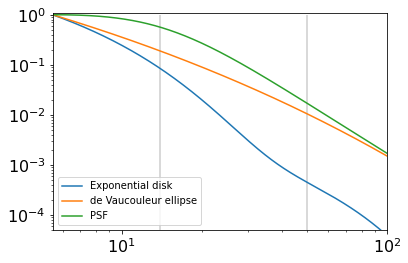

In [524]:
xp = np.linspace(5.5,100,1000)
disk = exponential(xp, radii['expRad_i']*dA).mean(axis=0)
ellipse = deVaucoleurs(xp, radii['deVRad_i']*dA).mean(axis=0)
dA = lcdm.angular_diameter_distance(radii['z']).to('kpc').value*u.arcsec.to('radian')
plt.loglog(xp, disk/disk.max(), label='Exponential disk')
plt.loglog(xp, ellipse/ellipse.max(), label='de Vaucouleur ellipse')
plt.loglog(xp, yp/yp.max(), label='PSF')
plt.vlines(14, 5e-5,1,color='k',alpha=0.2)
plt.vlines(50, 5e-5,1,color='k',alpha=0.2)
plt.ylim(5e-5,1.1)
plt.xlim(5.5,100)
plt.legend()

In [525]:
xp, total1, norm = xrb_psf_gal(radii)
xp, total2, norm2 = xrb_psf_gal(radii,model='Lehmer10')
xp, yp, norm3 = xrb_psf(radii)
xp, yp, norm4 = xrb_psf(radii,model='Lehmer10')

(1e+33, 1e+37)

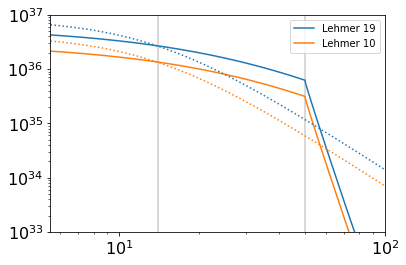

In [526]:
plt.loglog(xp, total1*norm, label='Lehmer 19')
plt.loglog(xp, total2*norm2, label='Lehmer 10')
plt.loglog(xp, yp*norm3, color='tab:blue', linestyle='dotted')
plt.loglog(xp, yp*norm4, color='tab:orange', linestyle='dotted')
plt.legend()
plt.vlines(14, 1e33,1e37,color='k',alpha=0.2)
plt.vlines(50, 1e33,1e37,color='k',alpha=0.2)
plt.xlim(5.5,100)
plt.ylim(1e33,1e37)

Text(0, 0.5, 'N')

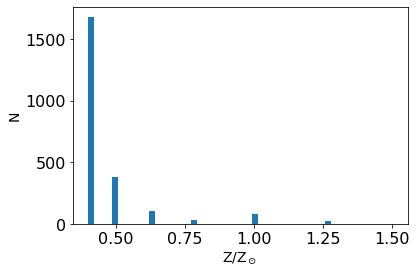

In [545]:
Z_sun=0.019
_ = plt.hist(radii['metallicity']/Z_sun, range=(0.4,1.5),bins=50)
plt.xlabel(r'Z/Z$_\odot$',fontsize=14)
plt.ylabel(r'N',fontsize=14)

In [478]:
gama = pd.read_csv('../gama.csv',header=0)
gama = gama.rename(columns={"RA":"ra","DEC":"dec","Z":"z"})
gs_inds = crossmatch(gama,sdss,tab=True)
dist = 3600*np.sqrt((sdss[gs_inds]['ra'] - gama['ra'])**2 + (sdss[gs_inds]['dec'] - gama['dec'])**2)
gama = gama[dist > 4] #genuinely new galaxies

In [479]:
sdss_gama = pd.DataFrame()
sdss_gama.insert(0, 'ra', np.concatenate((sdss['ra'].value,gama['ra'].values)))
sdss_gama.insert(1, 'dec', np.concatenate((sdss['dec'].value,gama['dec'].values)))
sdss_gama.insert(2, 'z', np.concatenate((sdss['z'].value,gama['z'].values)))
sdss_gama.insert(3, 'logMass', np.concatenate((sdss['logMass'].value,gama['mass_stellar_percentile50'].values)))
sdss_gama.insert(4, 'ssfr', np.concatenate((sdss['ssfr'].value,gama['sSFR_0_1Gyr_percentile50'].values)))
len(sdss_gama)

3118

[0.005 0.01  0.015 0.02  0.025 0.03  0.035 0.04  0.045 0.05  0.055 0.06
 0.065 0.07  0.075 0.08  0.085 0.09  0.095 0.1  ]
0.07488551182168056


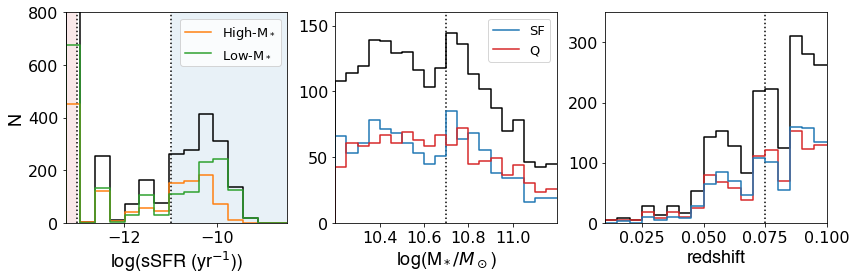

In [504]:
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
font = mpl.font_manager.FontProperties(family='helvetica', size=18)
(sdss_gama['ssfr'][sdss_gama['ssfr'] < -4]) = -4

low = sdss_gama[(sdss_gama['logMass'] < 10.7)*(sdss_gama['logMass'] > 10.2)]
high = sdss_gama[(sdss_gama['logMass'] > 10.7)*(sdss_gama['logMass'] < 11.2)]

fig, ax = plt.subplots(ncols = 3, figsize=(12,4))
ax1, ax2, ax3 = ax.flatten()
for a in (ax1, ax3): a.set_ylabel('N', fontsize=20, font=font)
    

hist, bins = np.histogram(sdss_gama['ssfr']-9, bins=30, range=(-18,-8.5))
ax1.step(bins[1:], hist, color='k')

hist, bins = np.histogram(high['ssfr']-9, bins=30, range=(-18,-8.5))
ax1.step(bins[1:], hist, color='tab:orange', label=r'High-M$_*$')
hist, bins = np.histogram(low['ssfr']-9, bins=30, range=(-18,-8.5))
ax1.step(bins[1:], hist, color='tab:green', label=r'Low-M$_*$')
ax1.legend(loc='best',fontsize=13)

ax1.set_xlabel(r'log(sSFR (yr$^{-1}$))', fontsize=16, font=font)

q = np.argsort(sdss_gama['ssfr'])[int(len(sdss)/3.)]
sf = np.argsort(sdss_gama['ssfr'])[int(2*len(sdss)/3.)]
sfr1 = sdss_gama['ssfr'][q] -9
sfr2 = sdss_gama['ssfr'][sf] -9
ax1.vlines(sfr2, 0, 900, color='k', linestyle='dotted')
ax1.vlines(sfr1, 0, 900, color='k', linestyle='dotted')
ax1.bar(sfr2, 900, width=(1-sfr2), align='edge', alpha=0.1, color='tab:blue')
ax1.bar(sfr1, 900, width=(sfr1-10), align='edge', alpha=0.1, color='tab:red')
ax1.set_xlim(-13.25,-8.5)
ax1.set_ylim(0,800)

q1 = np.argsort(low['ssfr'])[:int(len(low)/3.)]
sf1 = np.argsort(low['ssfr'])[int(2*len(low)/3.):]
q2 = np.argsort(high['ssfr'])[:int(len(high)/3.)]
sf2 = np.argsort(high['ssfr'])[int(2*len(high)/3.):]

sf = np.concatenate((low['logMass'].iloc[sf1], high['logMass'].iloc[sf2]))
q = np.concatenate((low['logMass'].iloc[q1], high['logMass'].iloc[q2]))

hist, bins = np.histogram(np.concatenate((sf,q)), bins=21, range=(10.15,11.2))
ax2.step(bins[1:], hist, color='k')
hist, bins = np.histogram(sf, bins=21, range=(10.15,11.2))
ax2.step(bins[1:], hist, color='tab:blue', label='SF')
hist, bins = np.histogram(q, bins=21, range=(10.15,11.2))
ax2.step(bins[1:], hist, color='tab:red', label='Q')
ax2.vlines(x=10.7,ymin=0,ymax=485,color='k',linestyles='dotted')
ax2.set_ylim(0,160)
ax2.set_xlabel(r'log(M$_*/M_\odot$)', fontsize=16,font=font)
ax2.set_xlim(10.2,11.2)
ax2.legend(loc='best',fontsize=13)
ax2.set_xticks([10.4, 10.6, 10.8, 11.0])

sf = np.concatenate((low['z'].iloc[q1], high['z'].iloc[q2]))
q = np.concatenate((low['z'].iloc[sf1], high['z'].iloc[sf2]))
zmean = np.mean(sdss_gama['z'][(sdss_gama['z'] > 0.01)*(sdss_gama['z'] < 0.1)])
ax3.vlines(x=zmean,ymin=0,ymax=550,color='k',linestyles='dotted')
hist, bins = np.histogram(np.concatenate((sf,q)), bins=19, range=(0.005,0.1))
ax3.step(bins[1:], hist, color='k')
hist, bins = np.histogram(sf, bins=19, range=(0.005,0.1))
ax3.step(bins[1:], hist, color='tab:red')
hist, bins = np.histogram(q, bins=19, range=(0.005,0.1))
print(bins)
ax3.step(bins[1:], hist, color='tab:blue')
ax3.set_xticks([0.025, 0.05, 0.075, 0.1])
ax3.set_xlim(0.01,0.1)

bins[np.argmax(hist)]
ax3.set_xlabel(r'redshift', fontsize=16, font=font)
ax3.set_ylim(0,350)

for a in ax.flatten(): ama = a.get_ylim()[1]; a.set_ylim(0,ama)
for a in [ax2,ax3]: a.set_ylabel('')

fig.tight_layout()
print(zmean)
plt.savefig('../galaxy-props-sdssgama.png', dpi=156)

In [495]:
aird = ascii.read('../aird_data.dat')
aird[(aird['z_lo'] == 0.1)]

Class,z_lo,z_hi,logMstel_lo,logMstel_hi,<log(SFR[Msun/yr])>,log<SFR[Msun/yr]>,log<lambda>,error_lo(68%),error_hi(68%)
str13,float64,float64,float64,float64,float64,float64,float64,float64,float64
Starburst,0.1,0.5,10.0,11.5,1.196,1.325,-2.237,0.301,0.331
Main-Sequence,0.1,0.5,10.0,11.5,0.651,0.747,-3.169,0.15,0.233
Sub-MS,0.1,0.5,10.0,11.5,0.08,0.21,-3.201,0.204,0.32
Qu-high,0.1,0.5,10.0,11.5,-0.884,-0.642,-3.134,0.356,0.457
Qu-low,0.1,0.5,10.0,11.5,-2.636,-2.242,-3.543,0.332,0.406
